# <center> Исследование данных HR-агентства

---

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В процессе анализа мы должны ответить на ключевые вопросы HR-агентства:

* Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
* Какие факторы влияют на зарплату у специалистов Data Scientist?
* Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?
* Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос попробуем ответить с уровнем значимости $\alpha=0.05$.

---

## Знакомство с данными

Ответить на эти вопросы нам помогут собранные HR-агентством данные о зарплатах и условиях труда в сфере Data Science.

Данные содержат следующие столбцы:
*   ***work_year*** — Год, в котором была выплачена зарплата.
*   ***experience_level*** — Опыт работы на этой должности в течение года со следующими возможными значениями: 
    * EN — Entry-level/Junior; 
    * MI — Mid-level/Intermediate;
    * SE — Senior-level/Expert; 
    * EX — Executive-level/Director.
*   ***employment_type*** — Тип трудоустройства для этой роли: 
    * PT — неполный рабочий день; 
    * FT — полный рабочий день; 
    * CT — контракт; 
    * FL — фриланс.
*   ***job_title*** — Роль, в которой соискатель работал в течение года.
*   ***salary*** — Общая выплаченная валовая сумма заработной платы.
*   ***salary_currency*** — Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
*   ***salary_in_usd*** — Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
*   ***employee_residence*** — Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
*   ***remote_ratio*** — Общий объём работы, выполняемой удалённо. Возможные значения:
    * 0 — удалённой работы нет (менее 20 %);
    * 50 — частично удалённая работа; 
    * 100 — полностью удалённая работа (более 80 %).
*   ***company_location*** — Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
*   ***company_size*** — Среднее количество людей, работавших в компании в течение года:
    * S — менее 50 сотрудников (небольшая компания);
    * M — от 50 до 250 сотрудников (средняя компания); 
    * L — более 250 сотрудников (крупная компания).

Оригинальный датасет: [“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries).

---

## Загрузка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import random

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [2]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.zip', index_col=[0])
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


---

## Работа с признаками и описательный анализ данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [4]:
print(f'Количество дубликатов: {data[data.duplicated()].shape[0]}')

Количество дубликатов: 42


In [5]:
data.drop_duplicates(inplace=True)
print('Количество строк после удаления дубликатов составляет: {}'.format(data.shape[0]))

Количество строк после удаления дубликатов составляет: 565


В таблице есть неактуальные для целей исследования признаки ***salary*** и ***salary_currency***: они просто-напросто избыточны при наличии стандартизированного признака ***salary_in_usd***. Поэтому их также удаляем.

In [6]:
data = data.drop(['salary', 'salary_currency'], axis=1)

Выведем описательную статистику для всех оставшихся признаков.

In [7]:
data.describe(include='all')

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,565.000000,565,565,565,565.000000,565,565.000000,565,565
unique,NaN,4,4,50,NaN,57,NaN,50,3
top,NaN,SE,FT,Data Scientist,NaN,US,NaN,US,M
freq,NaN,243,546,130,NaN,295,NaN,318,290
mean,2021.364602,NaN,NaN,NaN,110610.343363,NaN,69.911504,NaN,NaN
std,0.698138,NaN,NaN,NaN,72280.702792,NaN,40.900666,NaN,NaN
min,2020.000000,NaN,NaN,NaN,2859.000000,NaN,0.000000,NaN,NaN
25%,2021.000000,NaN,NaN,NaN,60757.000000,NaN,50.000000,NaN,NaN
50%,2021.000000,NaN,NaN,NaN,100000.000000,NaN,100.000000,NaN,NaN
75%,2022.000000,NaN,NaN,NaN,150000.000000,NaN,100.000000,NaN,NaN


Признак ***work_year*** удобнее было бы преобразовать в категориальный тип, т.к. он принимает всего три значения, то же самое относится к признаку ***remote_ratio***.

***employment_type*** почти польностью состоит из значения *FT* (Full time): на прочие три возможных значения остаются всего 19 строк в таблице. Поэтому от этого признака можно избавиться.

На основе признаков ***employee_residence*** и ***company_location*** можно создать вспомагательный признак, сообщающий о совпадении страны проживания специалиста и страны расположения работдателя.

Мы помним, что ключевые вопросы HR-агентства особенно затрагивают специальности Data Scientist и Data Engineer. Следовательно, есть смысл создать два новых признака в таблице: булевые признаки по расширенным спискам DS и DE-спецальностей. 

В итоге в данных должен остаться всего один числовой признак - ***salary_in_usd***, остальные же будут категориальными.

In [8]:
# Удалим признак employment_type.
data = data.drop(['employment_type'], axis=1)
# Создадим вспомогательный географический признак.
data['emplres_is_comploc'] = data['employee_residence'] == data['company_location']

# Сменим тип данных у ряда категориальных признаков, которые мы оставим без изменений.
# Список столбцов.
category_cols = list(data.columns)
category_cols.remove('salary_in_usd')
# Цикл по именам столбцов.
for col in category_cols:
    # Преобразуем тип столбца.
    data[col] = data[col].astype('category')

In [9]:
# Импортируем класс счетчиков из библиотеки коллекций.
from collections import Counter

# Создадим счетчик должностей.
job_title_cnt = Counter(data['job_title'])

# Сформируем объект-серию из счетчика.
job_title_cnt_s = pd.Series(job_title_cnt).sort_values(ascending=False).to_frame()
job_title_cnt_s.columns = ['Должность и частота его встречаемости:']
# Выведем первые десять специальностей по частоте встречаемости.
job_title_cnt_s.head(10)

,Должность и частота его встречаемости:
Data Scientist,130
Data Engineer,121
Data Analyst,82
Machine Learning Engineer,39
Research Scientist,16
Data Science Manager,12
Data Architect,11
Big Data Engineer,8
Machine Learning Scientist,8
Principal Data Scientist,7


Допустим, выборки для "сухих" DS и DE-специалистов уже достаточно репрезентативны для целей исследования, однако мы можем объединить схожие наименования специальностей, чтобы увеличить объемы анализируемых выборок.

In [10]:
# Формируем список всех специальностей.
lst_all_job_titles = list(job_title_cnt.keys())
# Отбираем с помощью цикла в соответствуеющие списки все наименования 
# содержащие в себе указанные текстовые маркеры.
lst_ds, lst_de = [], []
for x in lst_all_job_titles:
    if 'Data Scien' in x:
        lst_ds.append(x)
    if 'Data Engin' in x:
        lst_de.append(x)

# Создадим два новых вспомогательных категориальных признака.
data['is_ds'] = data['job_title'].apply(lambda x: 1 if x in lst_ds else 0)
data['is_de'] = data['job_title'].apply(lambda x: 1 if x in lst_de else 0)
# Объединим их значения для удобства в новом признаке.
data['is_ds_or_de'] = data['is_ds'] + data['is_de']

### Распределение заработных плат

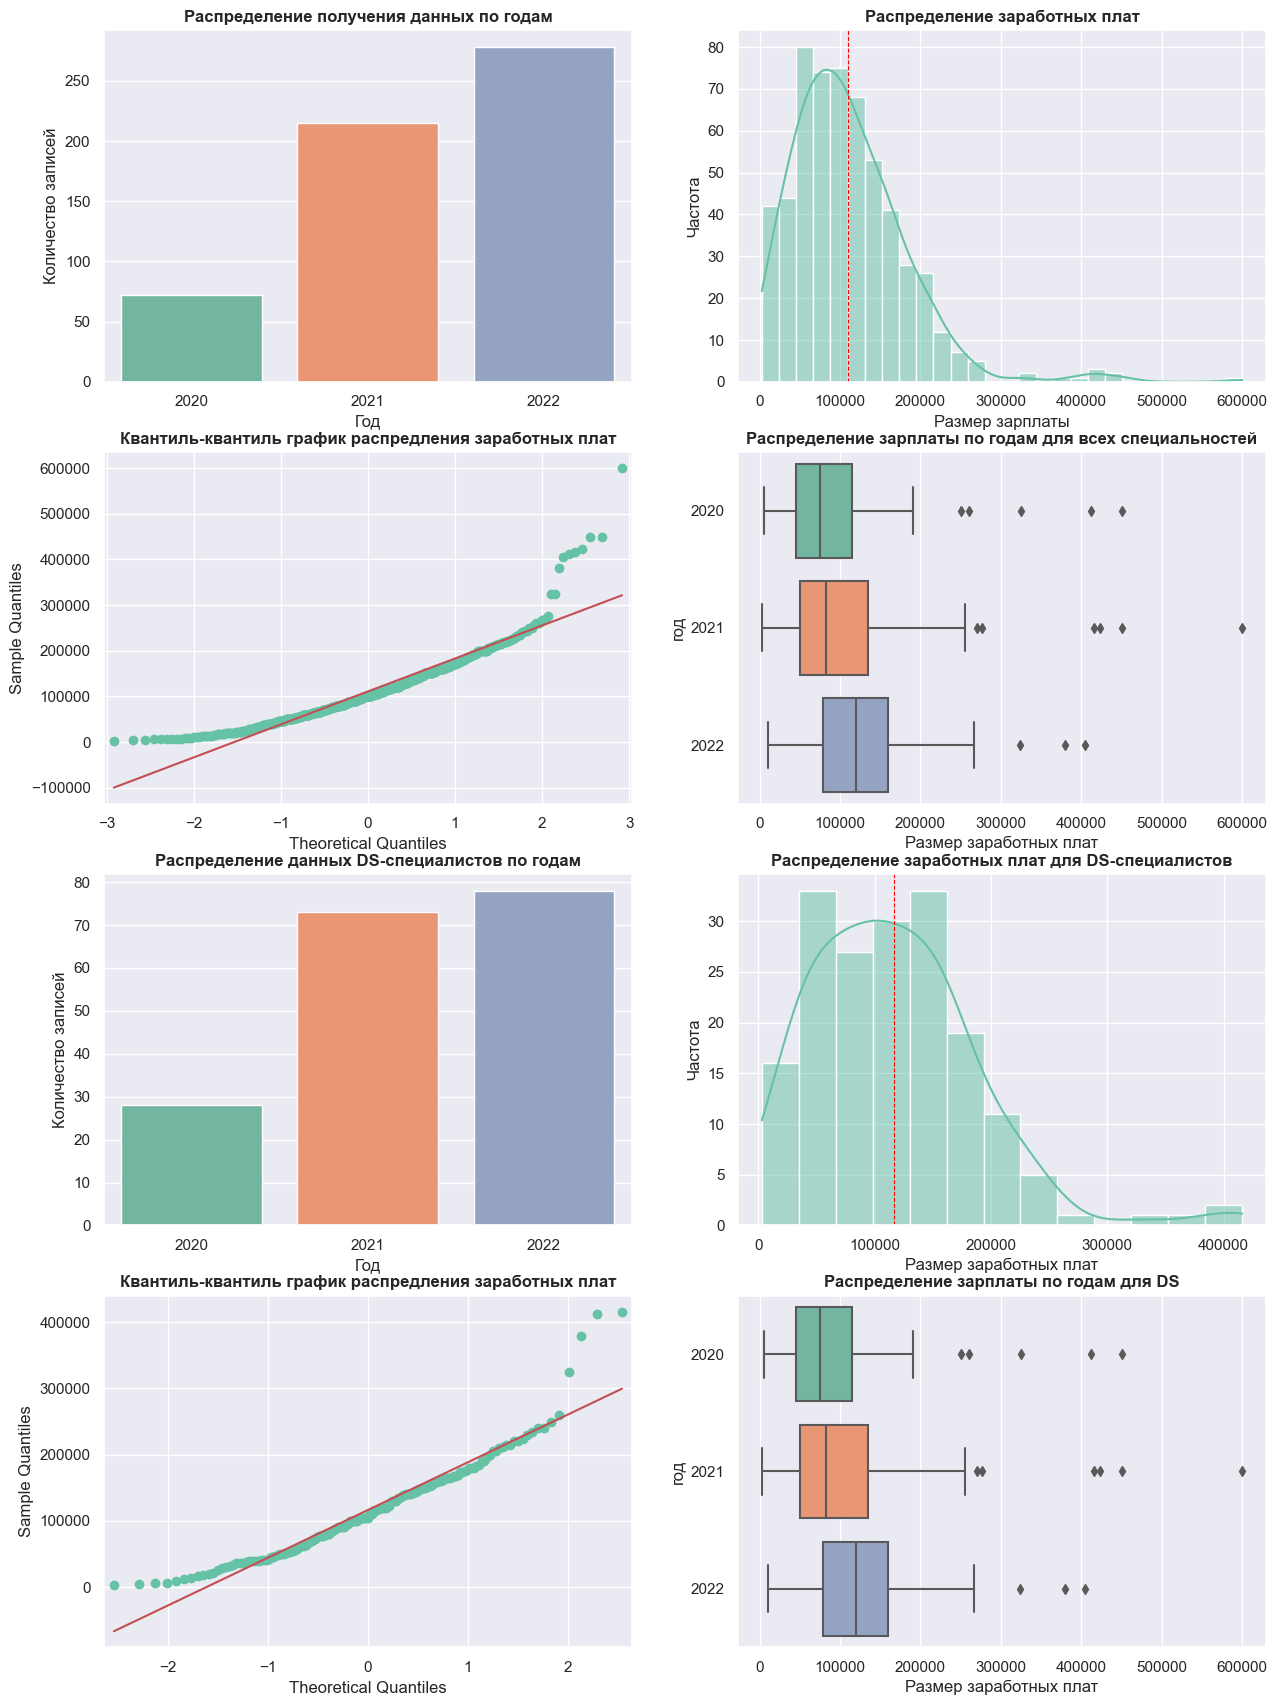

In [11]:
# Задаем параметры поля для графиков.
fig, axes = plt.subplots(4, 2, figsize=(15, 21))

# Гистограмма распределения данных по годам.
axes[0][0] = sns.countplot(x=data['work_year'], ax=axes[0][0])
axes[0][0].set(xlabel='Год', ylabel='Количество записей')
axes[0][0].set_title('Распределение получения данных по годам', weight='bold')

# Распределение частот заработных плат.
axes[0][1] = sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0][1])
axes[0][1].set(xlabel='Размер зарплаты', ylabel='Частота')
axes[0][1].set_title('Распределение заработных плат', weight='bold')
axes[0][1].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

# q-q график.
axes[1][0].set_title('Квантиль-квантиль график распредления заработных плат', weight='bold')
axes[1][0] = sm.qqplot(data['salary_in_usd'], line='s', ax=axes[1][0])

# Коробчатые диаграммы распределений заработных плат по годам для всех специальностей.
axes[1][1] = sns.boxplot(x=data['salary_in_usd'], y=data['work_year'], ax=axes[1][1])
axes[1][1].set(xlabel='Размер заработных плат', ylabel='год')
axes[1][1].set_title('Распределение зарплаты по годам для всех специальностей', weight='bold')

# Гистограмма распределения данных DS-специалистов по годам.
axes[2][0] = sns.countplot(x=data[data['is_ds'] == 1]['work_year'], ax=axes[2][0])
axes[2][0].set(xlabel='Год', ylabel='Количество записей')
axes[2][0].set_title('Распределение данных DS-специалистов по годам', weight='bold')

# Распределение частот заработных плат.
axes[2][1] = sns.histplot(x=data[data['is_ds'] == 1]['salary_in_usd'], kde=True, ax=axes[2][1])
axes[2][1].set(xlabel='Размер заработных плат', ylabel='Частота')
axes[2][1].set_title('Распределение заработных плат для DS-специалистов', weight='bold')
axes[2][1].axvline(data[data['is_ds'] == 1]['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

# q-q график.
axes[3][0].set_title('Квантиль-квантиль график распредления заработных плат', weight='bold')
axes[3][0] = sm.qqplot(data[data['is_ds'] == 1]['salary_in_usd'], line='s', ax=axes[3][0])

# Коробчатые диаграммы распределений заработных плат по годам для DS-специальностей.
axes[3][1] = sns.boxplot(data=data[data['is_ds'] == 1], x=data['salary_in_usd'], y=data['work_year'], ax=axes[3][1])
axes[3][1].set(xlabel='Размер заработных плат', ylabel='год')
axes[3][1].set_title('Распределение зарплаты по годам для DS', weight='bold')

plt.show()

In [12]:
# Выведем описательную статистику для распределения з/п.
data_agg = data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Заработные платы в зависимости от года для всех специалистов')
display(data_agg)

data_ds = data[data['is_ds'] == 1]

data_ds_agg = data_ds.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Заработные платы в зависимости от года для специалистов DS')
display(data_ds_agg)

data_de = data[data['is_de'] == 1]

data_de_agg = data_de.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Заработные платы в зависимости от года для специалистов DE')
data_de_agg

Заработные платы в зависимости от года для всех специалистов


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,215.0,99430.41,80304.32,2859.0,50000.0,82528.0,135000.0,600000.0
2022,278.0,123089.10,59888.93,10000.0,78791.0,120000.0,160000.0,405000.0


Заработные платы в зависимости от года для специалистов DS


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,28.0,102948.18,89203.03,5707.0,44869.25,78395.5,118500.0,412000.0
2021,73.0,96397.90,69450.25,2859.0,49646.00,87738.0,130026.0,416000.0
2022,78.0,139940.54,61627.85,18442.0,100000.00,140400.0,176750.0,380000.0


Заработные платы в зависимости от года для специалистов DE


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,18.0,87943.83,39351.66,33511.0,56825.75,76981.5,112154.0,188000.0
2021,49.0,105084.33,95882.01,4000.0,30428.00,90000.0,150000.0,600000.0
2022,80.0,124570.98,57484.10,25000.0,78526.00,116394.5,160020.0,324000.0


**Выводы**

Из полученных графиков мы видим:
1. Большинство полученных записей приходится на 2021 и 2022 год;
2. Распределение заработных плат имеет выбросы, есть 2 вершины, присутствует асимметрия.
3. Распределение на большей части среднего участка в q-q графике близко к нормальному.
4. Уровень заработной платы из года в год растет, самый большой выброс приходится на 2021 год.
5. Распределение записей по годам повинуется порядку общего распределения.
6. График распределения зарплат для DS выглядит нормальным, но имеются две вершины, выбросы и асимметрия.
7. Распределение на большей части среднего участкав q-q графике в этом случае также близко к нормальному.
8. Заработные платы для DS-специалистов из года в год также растут.

Пожалуй, мы уже можем предварительно ответить на первый ключевой вопрос hr-агентства - наблюдается ли ежегодный рост зарплат у специалистов Data Science? В действительности мы наблюдаем рост зарплат не только у DS-специалистов, но и у всех остальных. Однако размеры групп, распредленных по годам, получились довольно разными, и чтобы определить, являются ли различия по заработным платам статистически значимыми, в следующем разделе мы проведём соответствующее статистическое тестирование.

###  Распределение заработных плат в зависимости от уровня квалификации

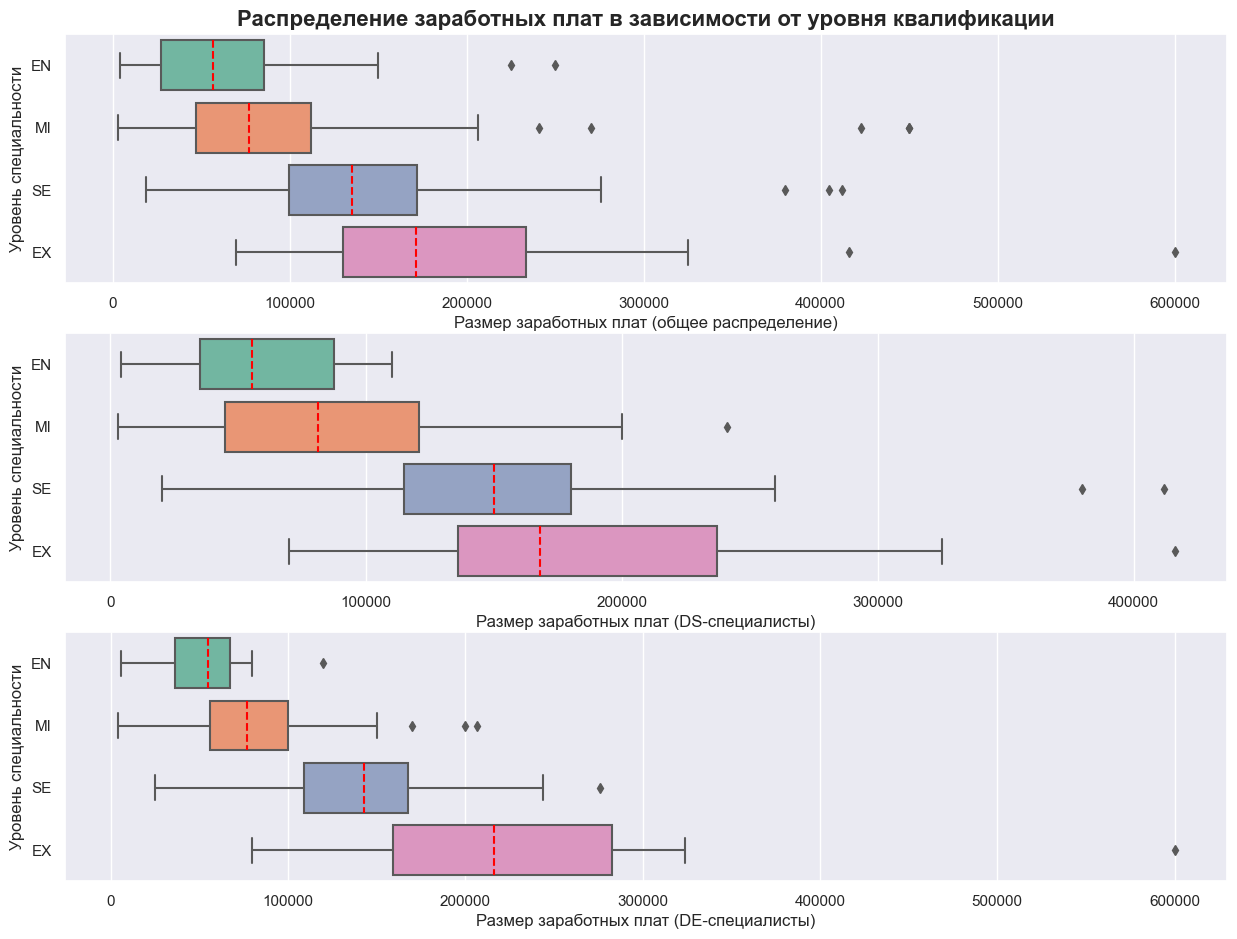

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(15, 11))
order = ['EN', 'MI', 'SE', 'EX']

sns.boxplot(x=data['salary_in_usd'], y=data['experience_level'], orient='h',
            medianprops={"color": "red", "linestyle": '--'}, order=order, ax=axes[0])
axes[0].set(xlabel='Размер заработных плат (общее распределение)', ylabel='Уровень специальности')
axes[0].set_title('Распределение заработных плат в зависимости от уровня квалификации',
                  weight='bold', size=16)

sns.boxplot(x=data_ds['salary_in_usd'], y=data_ds['experience_level'], orient='h',
            medianprops={"color": "red", "linestyle": '--'}, order=order, ax=axes[1])
axes[1].set(xlabel='Размер заработных плат (DS-специалисты)', ylabel='Уровень специальности')

sns.boxplot(x=data_de['salary_in_usd'], y=data_de['experience_level'], orient='h',
            medianprops={"color": "red", "linestyle": '--'}, order=order, ax=axes[2])
axes[2].set(xlabel='Размер заработных плат (DE-специалисты)', ylabel='Уровень специальности')

plt.show()

In [14]:
data_agg = data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Распределение заработных плат по опыту работы для всех специалистов')
display(data_agg)

data_ds_agg = data_ds.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Распределение заработных плат по опыту работы для DS-специалистов')
display(data_ds_agg)

data_de_agg = data_de.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Распределение заработных плат по опыту работы для DE-специалистов')
data_de_agg

Распределение заработных плат по опыту работы для всех специалистов


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.0,61643.32,44395.54,4000.0,27505.00,56500.0,85425.75,250000.0
EX,26.0,199392.04,117071.26,69741.0,130006.50,171437.5,233750.00,600000.0
MI,208.0,87793.00,64118.97,2859.0,47163.75,76940.0,112075.00,450000.0
SE,243.0,138374.88,59955.97,18907.0,99531.50,135000.0,171881.00,412000.0


Распределение заработных плат по опыту работы для DS-специалистов


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,28.0,58590.04,32115.87,4000.0,34920.00,55198.0,87527.25,110037.0
EX,11.0,196375.82,103378.46,69741.0,135936.00,167875.0,237000.00,416000.0
MI,68.0,87677.07,50927.20,2859.0,44869.25,81166.5,120586.50,241000.0
SE,72.0,153781.42,65319.66,20171.0,114591.75,150000.0,180000.00,412000.0


Распределение заработных плат по опыту работы для DE-специалистов


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,15.0,53287.47,28595.99,5882.0,36058.5,54742.0,67506.5,120000.0
EX,7.0,254288.57,172191.14,79833.0,159093.5,216000.0,283000.0,600000.0
MI,57.0,80419.68,42043.26,4000.0,56000.0,76940.0,100000.0,206699.0
SE,68.0,140213.90,49068.56,25000.0,108968.0,142625.0,167550.0,276000.0


Расшифровка:
* EN — Entry-level/Junior;
* EX — Executive-level/Director;
* MI — Mid-level/Intermediate;
* SE — Senior-level/Expert.

**Вывод**

Зависимость, продемонстрированная в этом случае, уже и так интуитивно очевидная, подтверждает наши ожидания: с ростом опыта растет и зарплата. Обратное вряд ли является частым явлением на рынке труда. Необходимость проводить какое-либо тестирование для определения статистической значимости различий здесь неочевидна.

### Зависимость заработной платы от должности

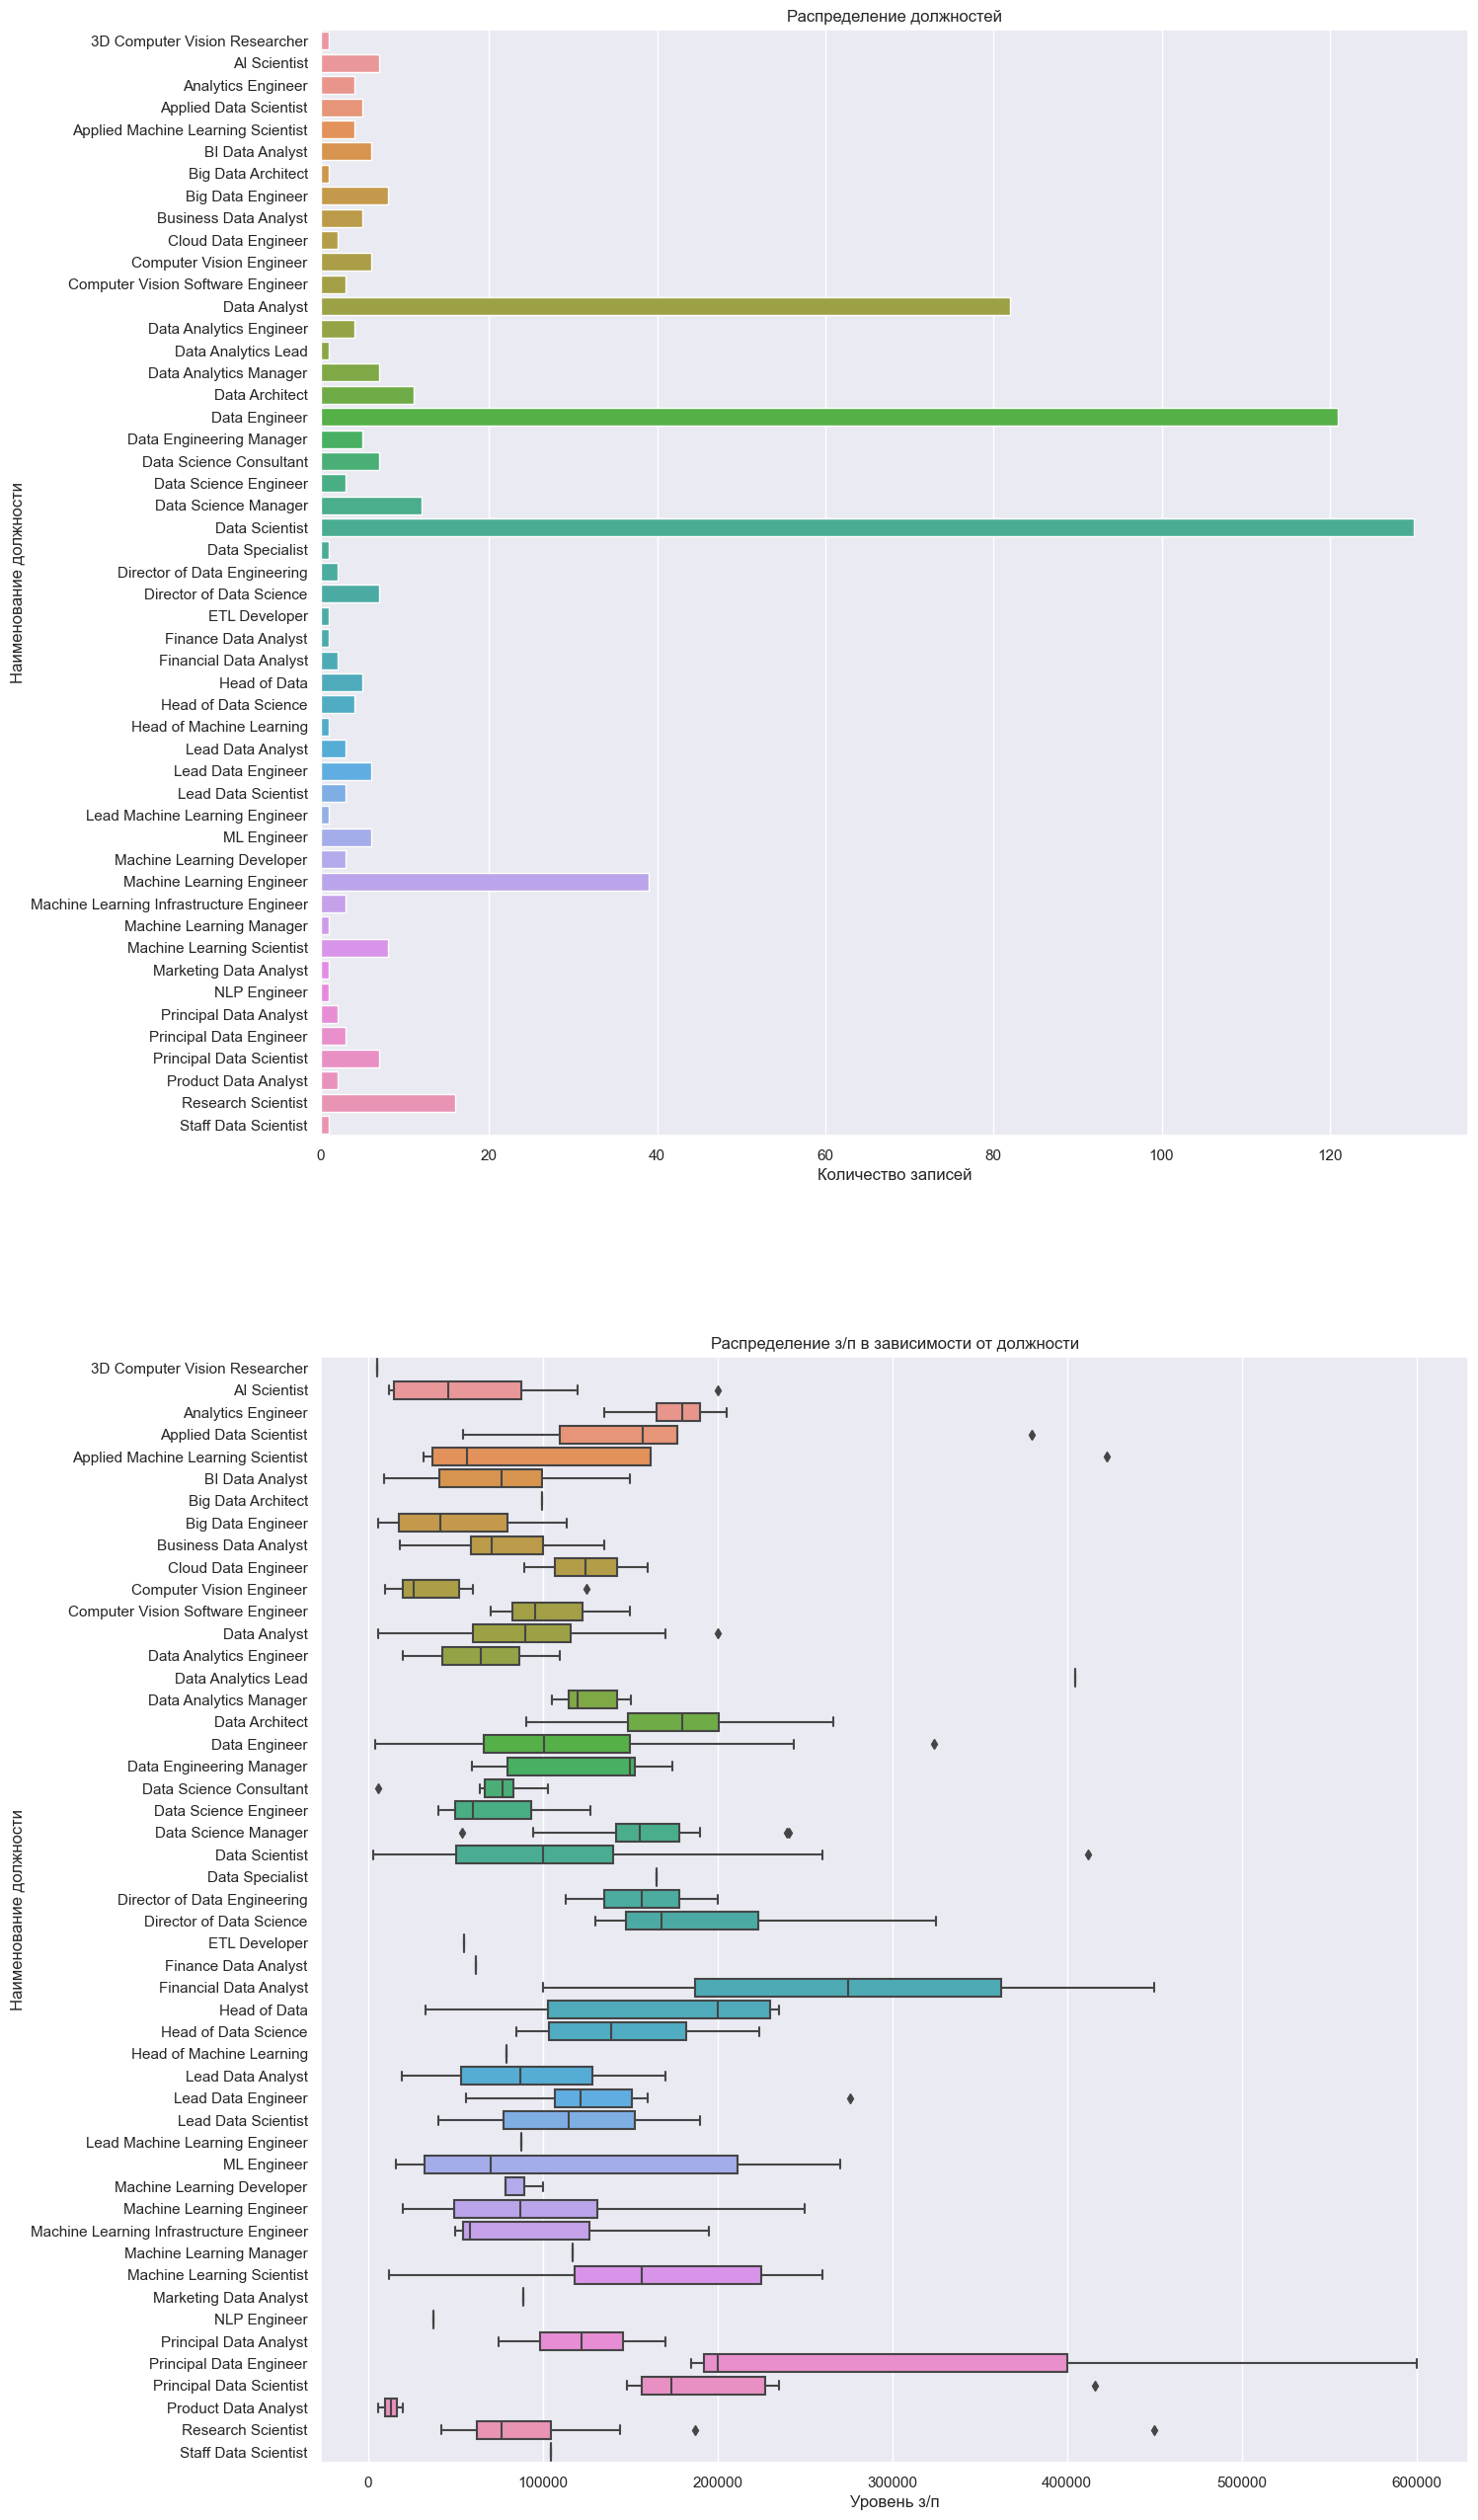

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(15, 32))

axes[0] = sns.countplot(data=data, y=data['job_title'], ax=axes[0])
axes[0].set(xlabel='Количество записей', ylabel='Наименование должности')
axes[0].set_title('Распределение должностей')

axes[1] = sns.boxplot(data=data, y=data['job_title'], x=data['salary_in_usd'], ax=axes[1])
axes[1].set(xlabel='Уровень з/п', ylabel='Наименование должности')
axes[1].set_title('Распределение з/п в зависимости от должности')

plt.show()

**Вывод**

Как видим, самый сильный выброс принадлежит профессии Principal Data Engineer, представленной в данных всего тремя специалистами. Вторым идет Financial Data Analyst с двумя специалистами. Прочие профессии, в случае если они представлены числом специалистов не менее десяти, имеют примерно схожую заработную плату, редко превышающую 250000 usd.

### Зависимость заработной платы от основной страны проживания специалиста

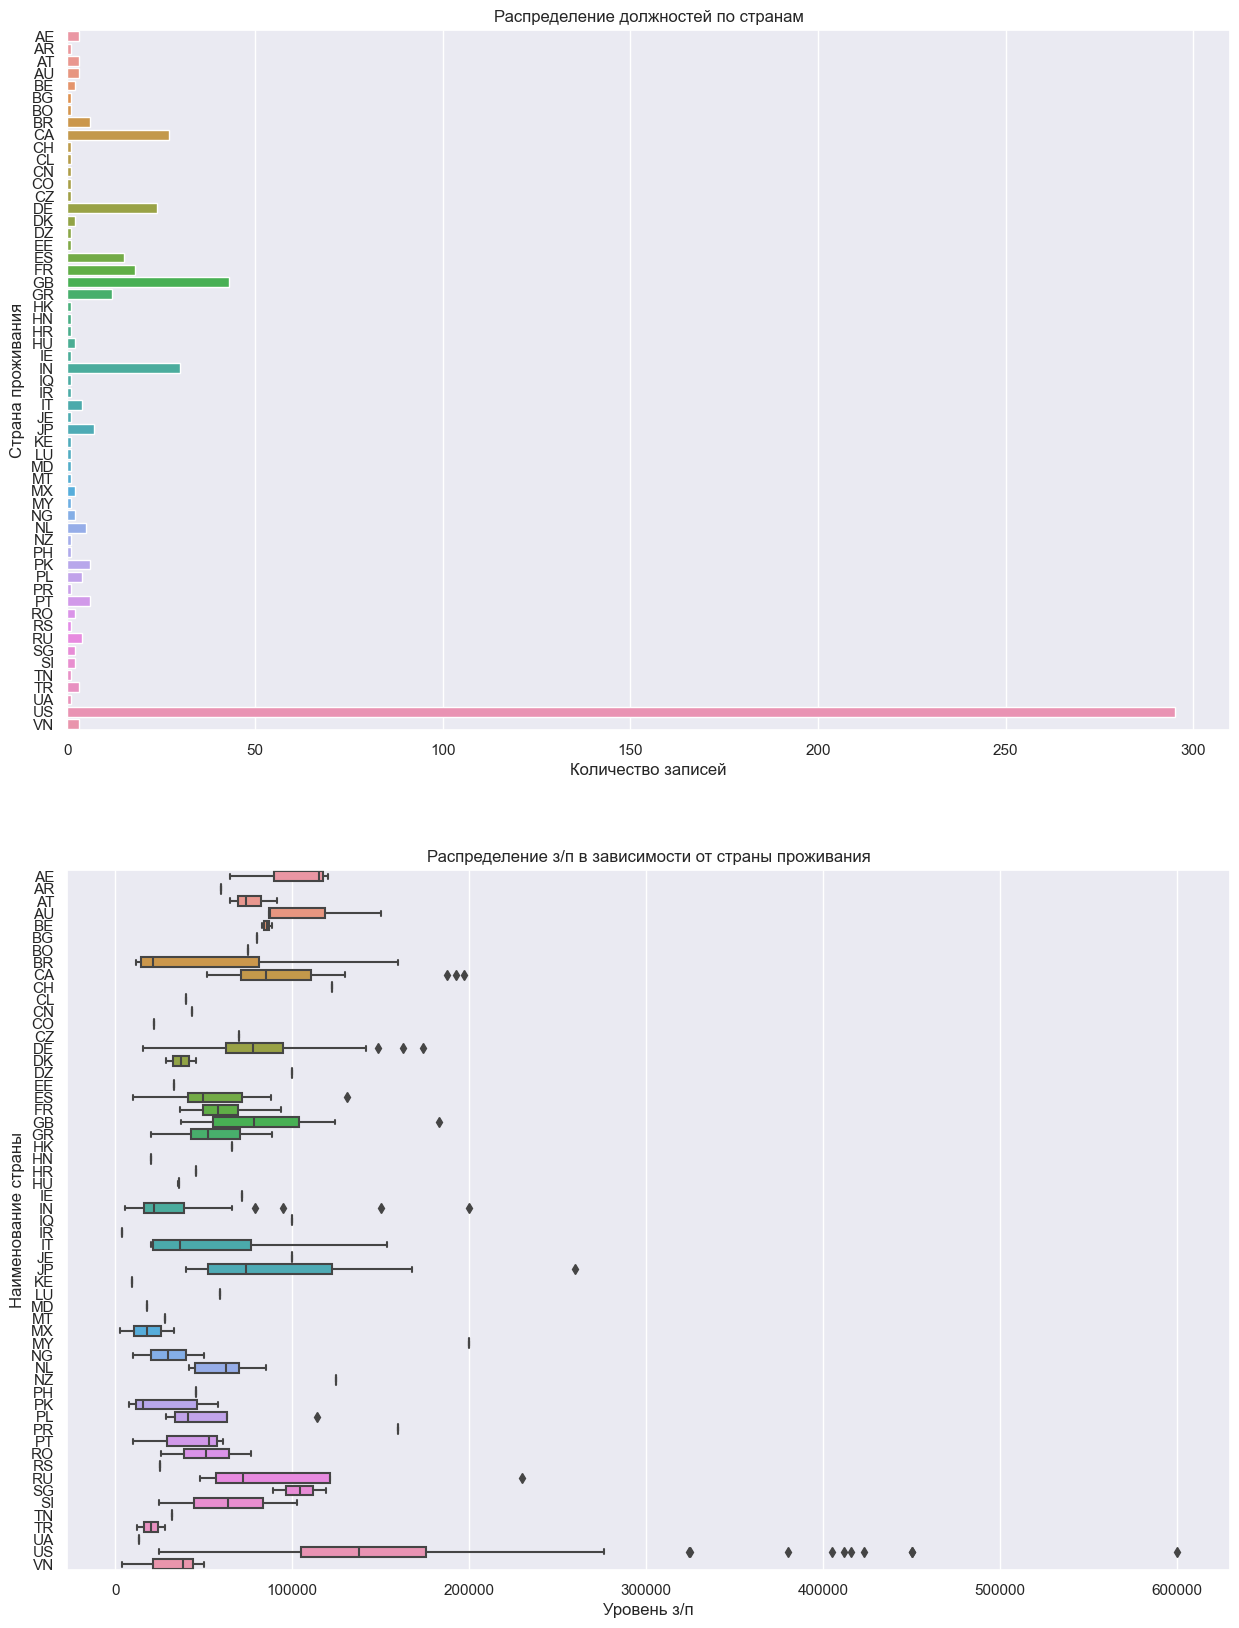

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(15, 20))

axes[0] = sns.countplot(data=data, y=data['employee_residence'], ax=axes[0])
axes[0].set(xlabel='Количество записей', ylabel='Страна проживания')
axes[0].set_title('Распределение должностей по странам')


axes[1] = sns.boxplot(data=data, y=data['employee_residence'], x=data['salary_in_usd'], ax=axes[1])
axes[1].set(xlabel='Уровень з/п', ylabel='Наименование страны')
axes[1].set_title('Распределение з/п в зависимости от страны проживания')

plt.show()

**Вывод**

Большинство специалистов проживают в США - они же получают и самые высокие зарплаты. Выбросов для распределения заработных плат среди проживающих в США также больше всего.

### Зависимость распределения заработных плат от объема работ, выполняемых удаленно

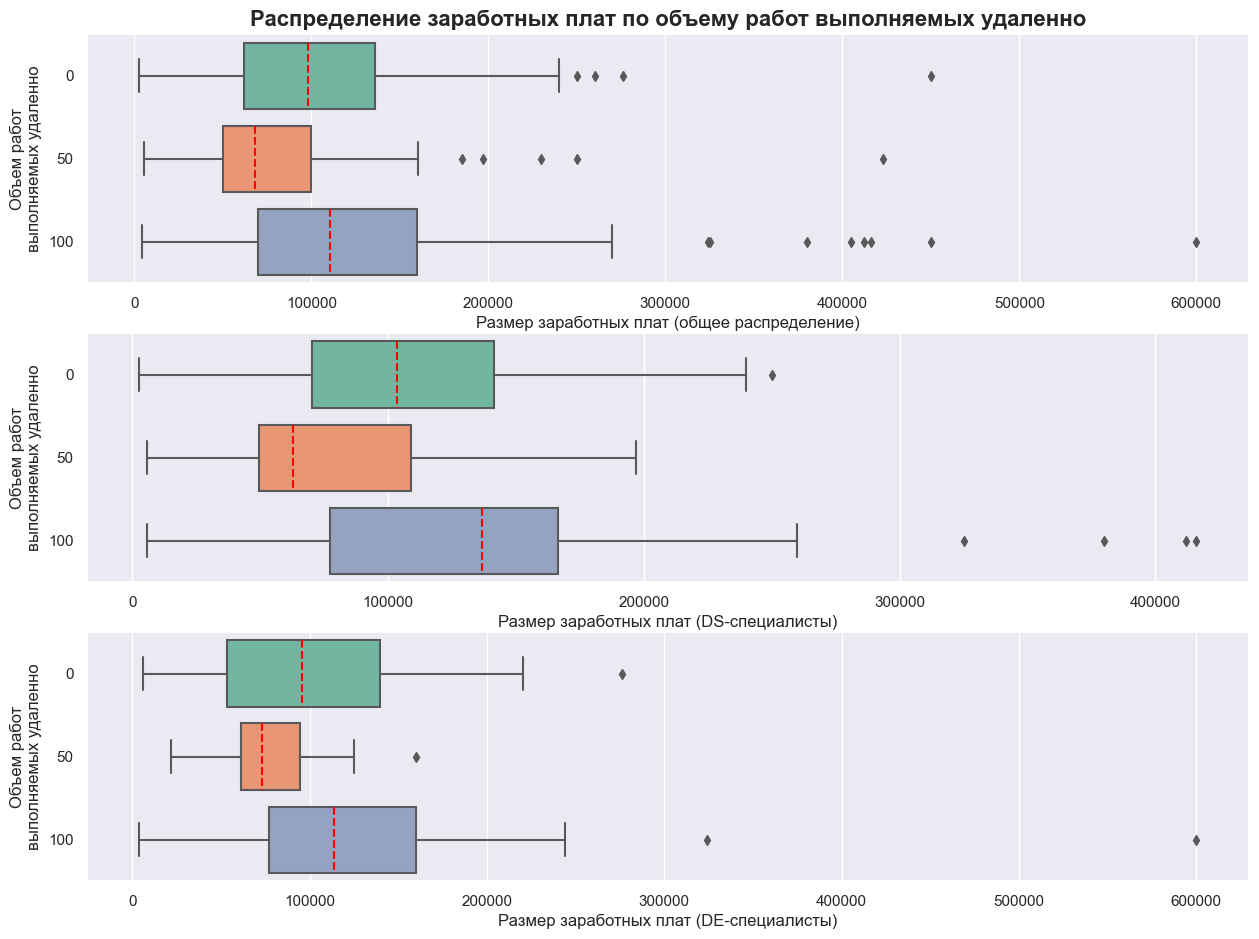

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(15, 11))

sns.boxplot(x=data['salary_in_usd'], y=data['remote_ratio'], orient='h',
            medianprops={"color": "red", "linestyle": '--'}, ax=axes[0])
axes[0].set(xlabel='Размер заработных плат (общее распределение)', ylabel='Объем работ\nвыполняемых удаленно')
axes[0].set_title('Распределение заработных плат по объему работ выполняемых удаленно',
                  weight='bold', size=16)

sns.boxplot(x=data_ds['salary_in_usd'], y=data_ds['remote_ratio'], orient='h',
            medianprops={"color": "red", "linestyle": '--'}, ax=axes[1])
axes[1].set(xlabel='Размер заработных плат (DS-специалисты)', ylabel='Объем работ\nвыполняемых удаленно')

sns.boxplot(x=data_de['salary_in_usd'], y=data_de['remote_ratio'], orient='h',
            medianprops={"color": "red", "linestyle": '--'}, ax=axes[2])
axes[2].set(xlabel='Размер заработных плат (DE-специалисты)', ylabel='Объем работ\nвыполняемых удаленно')

plt.show()

In [18]:
data_agg = data.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Распределение заработных плат для всех специалистов по объему работ выполняемых удаленно')
display(data_agg)

data_ds_agg = data_ds.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Распределение заработных плат для DS-специалистов по объему работ выполняемых удаленно')
display(data_ds_agg)

data_de_agg = data_de.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Распределение заработных плат для DE-специалистов по объему работ выполняемых удаленно')
data_de_agg

Распределение заработных плат для всех специалистов по объему работ выполняемых удаленно


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,121.0,105785.40,68392.50,2859.0,62000.0,98158.0,136000.00,450000.0
50,98.0,80721.90,57639.10,5409.0,50000.5,68010.5,99925.75,423000.0
100,346.0,120763.19,74930.43,4000.0,70000.0,110712.5,159750.00,600000.0


Распределение заработных плат для DS-специалистов по объему работ выполняемых удаленно


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,48.0,109533.85,63086.31,2859.0,70346.0,103401.0,141436.5,250000.0
50,33.0,76945.42,42593.81,5707.0,49646.0,62726.0,109000.0,196979.0
100,98.0,133042.18,79052.47,5679.0,77218.5,136880.5,166555.0,416000.0


Распределение заработных плат для DE-специалистов по объему работ выполняемых удаленно


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,32.0,100442.94,66012.00,5882.0,53587.75,95654.0,139500.0,276000.0
50,18.0,78306.44,33781.17,21637.0,61253.25,73171.0,94535.0,160000.0
100,97.0,124475.35,76360.45,4000.0,76940.00,113476.0,160000.0,600000.0


**Вывод**

Здесь мы наблюдаем уже нечто более интересное. Во-первых, большинство специалистов в основной группе и в обоих подгруппах выполняют всю работу удаленно. Во-вторых, любопытна ситуация с "50%-специалистами": их доля во всех трех случаях наименьшая и зарабатывают они тоже меньше остальных (визуально - удаленщики получают лишь чуть больше офисных работников). Возможно, в этот раз мы имеем дело с большим влиянием третьих, неучтенных, факторов. И если ситуация с 50%-группами более менее наглядна, то различие 0%-группами и 100%-группами еще стоит проверить статистически.

### Зависимость заработных плат от страны работодателя

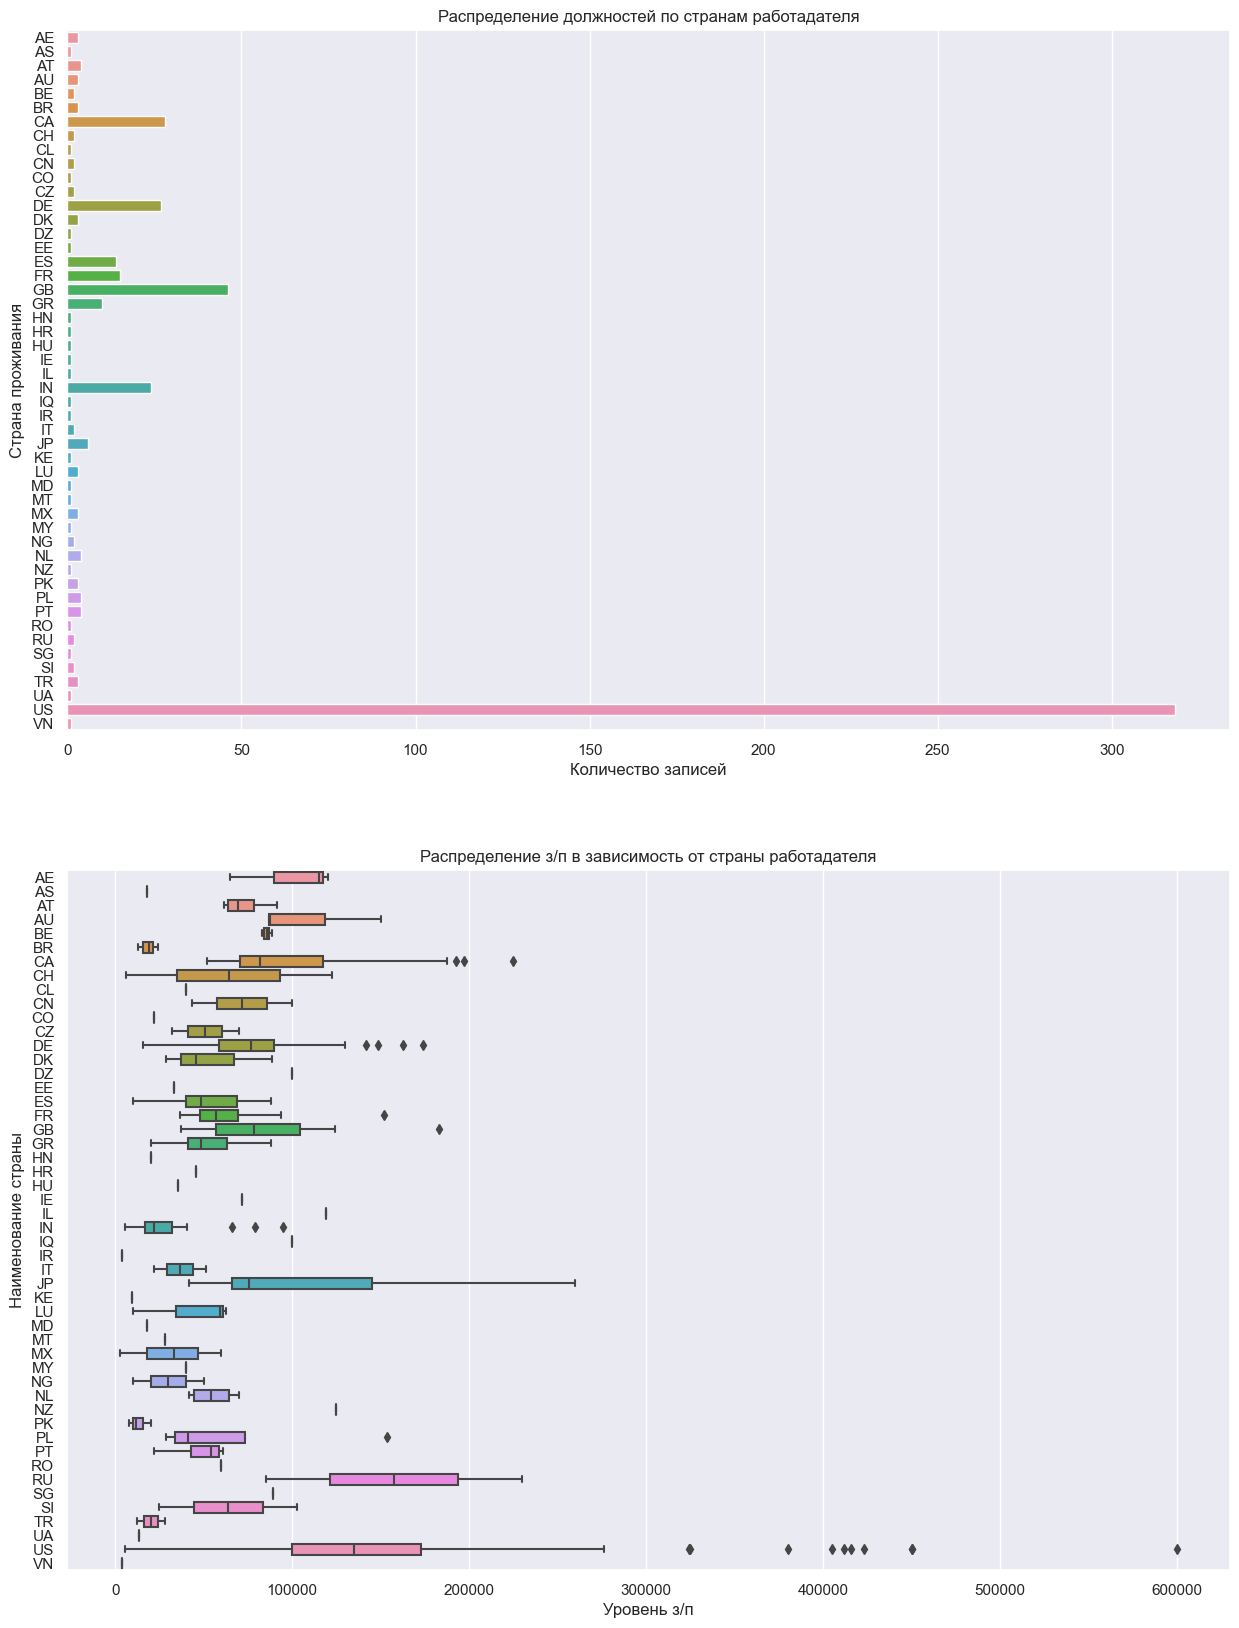

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(15, 20))

axes[0] = sns.countplot(data=data, y=data['company_location'], ax=axes[0])
axes[0].set(xlabel='Количество записей', ylabel='Страна проживания')
axes[0].set_title('Распределение должностей по странам работадателя')

axes[1] = sns.boxplot(data=data, y=data['company_location'], x=data['salary_in_usd'], ax=axes[1])
axes[1].set(xlabel='Уровень з/п', ylabel='Наименование страны')
axes[1].set_title('Распределение з/п в зависимость от страны работадателя')

plt.show()

**Вывод**

Больше всего заработная плата у специалистов, работабщих на компании из США. Следом идут сотрудники японских, российских и канадаских компаний. Остальные получают в районе 50-100 тыс. usd.

### Зависимость распределения заработных плат от размера компаний

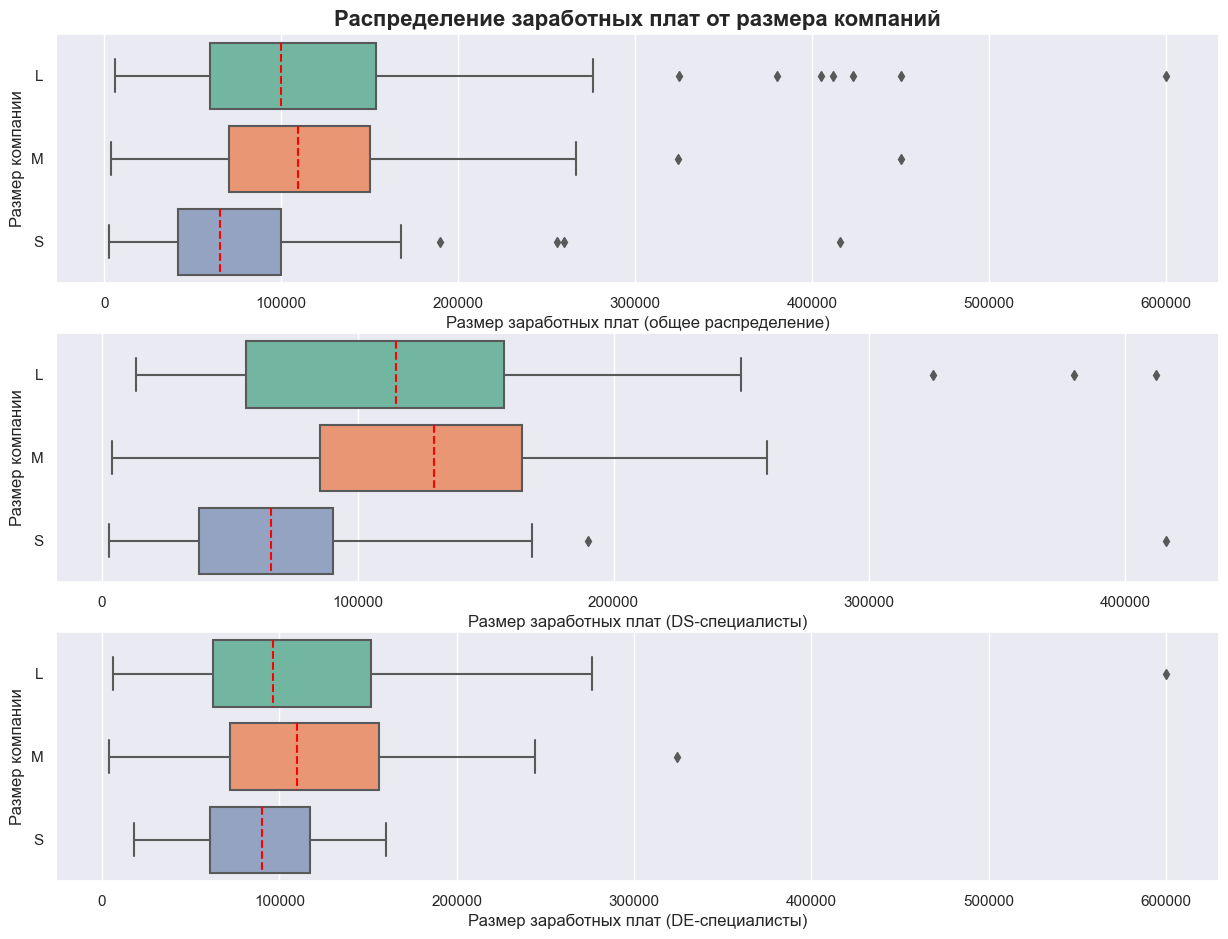

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(15, 11))

sns.boxplot(x=data['salary_in_usd'],
            y=data['company_size'], orient='h',
            medianprops={"color": "red", "linestyle": '--'},
            ax=axes[0])
axes[0].set(xlabel='Размер заработных плат (общее распределение)', ylabel='Размер компании')
axes[0].set_title('Распределение заработных плат от размера компаний', weight='bold', size=16)

sns.boxplot(x=data_ds['salary_in_usd'],
            y=data_ds['company_size'], orient='h',
            medianprops={"color": "red", "linestyle": '--'},
            ax=axes[1])
axes[1].set(xlabel='Размер заработных плат (DS-специалисты)', ylabel='Размер компании')

sns.boxplot(x=data_de['salary_in_usd'],
            y=data_de['company_size'], orient='h',
            medianprops={"color": "red", "linestyle": '--'},
            ax=axes[2])
axes[2].set(xlabel='Размер заработных плат (DE-специалисты)', ylabel='Размер компании')

plt.show()

In [21]:
data_agg = data.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Распределение заработных плат для всех специалистов по размерам компаний')
display(data_agg)

data_ds_agg = data_ds.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Распределение заработных плат для DS-специалистов по размерам компаний')
display(data_ds_agg)

data_de_agg = data_de.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Распределение заработных плат для DE-специалистов по размерам компаний')
data_de_agg

Распределение заработных плат для всех специалистов по размерам компаний


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,193.0,118213.88,86753.27,5882.0,60000.0,100000.0,153667.00,600000.0
M,290.0,114807.08,60779.04,4000.0,70821.5,109640.0,150213.75,450000.0
S,82.0,77872.10,63814.52,2859.0,41816.0,65511.0,100000.00,416000.0


Распределение заработных плат для DS-специалистов по размерам компаний


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,69.0,121955.77,80841.56,13400.0,56256.00,115000.0,157000.00,412000.0
M,82.0,124499.94,57571.25,4000.0,85425.75,130000.0,164418.50,260000.0
S,28.0,78964.82,79917.35,2859.0,38030.75,66233.5,90309.25,416000.0


Распределение заработных плат для DE-специалистов по размерам компаний


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,47.0,113098.28,94845.54,5882.0,62349.00,96282.0,151500.00,600000.0
M,86.0,117749.16,59820.77,4000.0,72110.00,109762.0,156200.00,324000.0
S,14.0,89696.57,44909.52,18000.0,60727.25,89996.5,117390.25,160000.0


**Вывод**

Число учтенных в базе hr-агентства специалистов из малых компаний меньше остальных. И наименьшие зарплаты наблюдаются тоже именно у них: возможно, это объяснимо тем, что маленькая компания вряд ли способна взяться за большой и дорогой проект и часто вынуждена существовать подпитываясь запасом энтузиазма своих специалистов.

Более интересным будет проверка статистической значимости разницы заработных плат между группами из средних и больших компаний.

Здесь мы также можем попробовать ответить на третий ключевой вопрос hr-агентства - как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях? Любопытно, что выборки по группированным значениям в обоих датафреймах почти одной величины - их будет проще сравнивать в статистических тестах. Однако уже сейчас можно заметить: что в малых компаниях труд DE-специалистов будто бы поощряется больше; в средних компаниях преимущество у DS-специалистов; в крупных - тоже, но здесь оно менее выражено. Так или иначе, ясности в вопросе станет больше на этапе стат-тестирования.

### Зависимость распределения заработных плат от географической удаленности

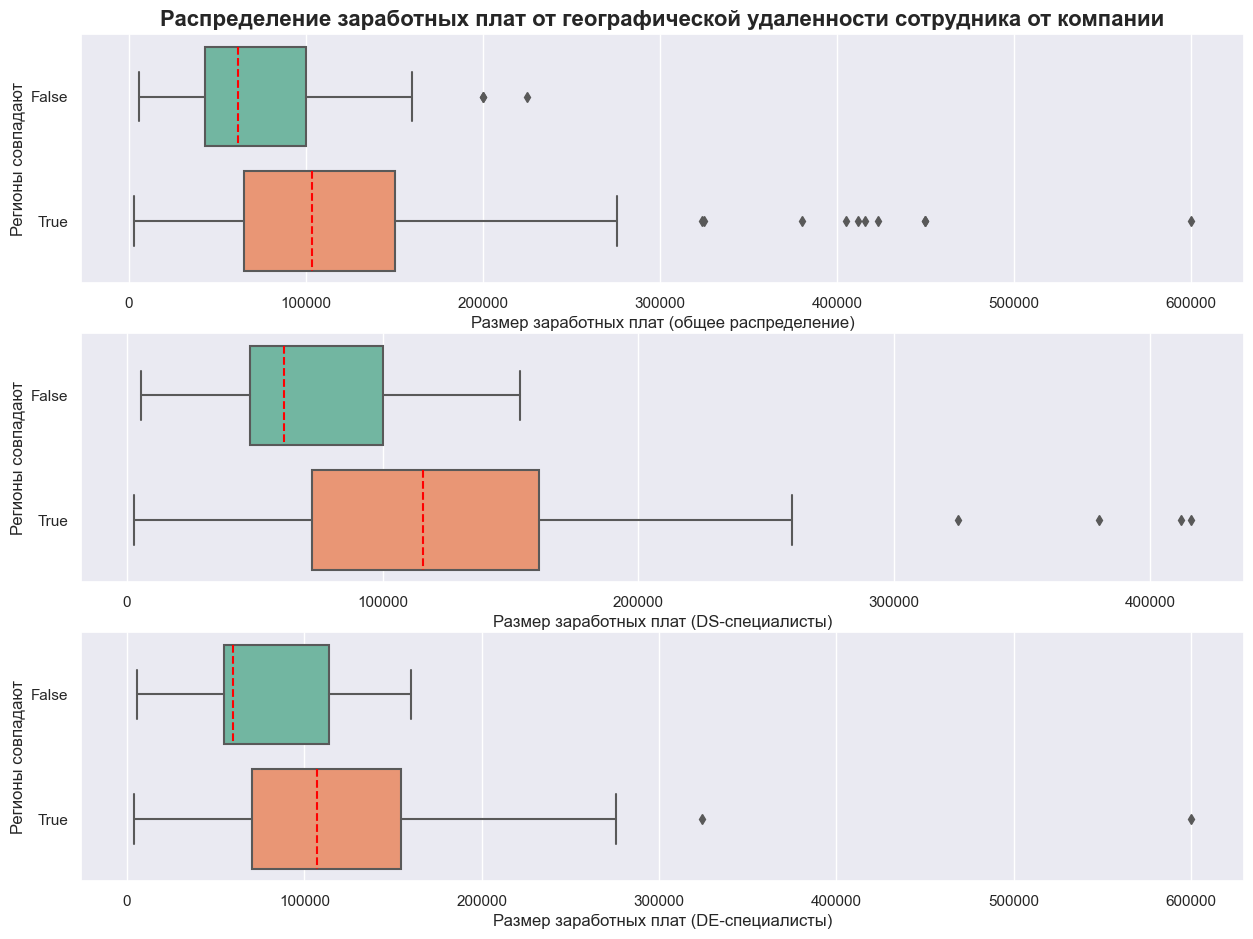

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(15, 11))

sns.boxplot(x=data['salary_in_usd'], y=data['emplres_is_comploc'], orient='h',
            medianprops={"color": "red", "linestyle": '--'}, ax=axes[0])
axes[0].set(xlabel='Размер заработных плат (общее распределение)', ylabel='Регионы совпадают')
axes[0].set_title('Распределение заработных плат от географической удаленности сотрудника от компании',
                  weight='bold', size=16)

sns.boxplot(x=data_ds['salary_in_usd'], y=data_ds['emplres_is_comploc'], orient='h',
            medianprops={"color": "red", "linestyle": '--'}, ax=axes[1])
axes[1].set(xlabel='Размер заработных плат (DS-специалисты)', ylabel='Регионы совпадают')

sns.boxplot(x=data_de['salary_in_usd'], y=data_de['emplres_is_comploc'], orient='h',
            medianprops={"color": "red", "linestyle": '--'}, ax=axes[2])
axes[2].set(xlabel='Размер заработных плат (DE-специалисты)', ylabel='Регионы совпадают')

plt.show()

In [23]:
data_agg = data.groupby('emplres_is_comploc')['salary_in_usd'].describe().round(2)
print('Распределение заработных плат от географической удаленности сотрудника от компании')
display(data_agg)

data_ds_agg = data_ds.groupby('emplres_is_comploc')['salary_in_usd'].describe().round(2)
print('Распределение заработных плат для DS-специалистов от географической удаленности сотрудника от компании')
display(data_ds_agg)

data_de_agg = data_de.groupby('emplres_is_comploc')['salary_in_usd'].describe().round(2)
print('Распределение заработных плат для DE-специалистов от географической удаленности сотрудника от компании')
data_de_agg

Распределение заработных плат от географической удаленности сотрудника от компании


,count,mean,std,min,25%,50%,75%,max
emplres_is_comploc,,,,,,,,
False,51.0,76758.35,52888.51,5679.0,42880.00,61467.0,100000.0,225000.0
True,514.0,113969.20,73116.58,2859.0,64886.75,103425.5,150000.0,600000.0


Распределение заработных плат для DS-специалистов от географической удаленности сотрудника от компании


,count,mean,std,min,25%,50%,75%,max
emplres_is_comploc,,,,,,,,
False,17.0,71787.71,40844.6,5679.0,48000.0,61467.0,100000.0,153667.0
True,162.0,121077.57,73425.3,2859.0,72236.5,115957.0,161006.5,416000.0


Распределение заработных плат для DE-специалистов от географической удаленности сотрудника от компании


,count,mean,std,min,25%,50%,75%,max
emplres_is_comploc,,,,,,,,
False,13.0,76028.15,50535.08,5882.0,54742.00,60000.0,114047.0,160000.0
True,134.0,117234.57,72698.76,4000.0,70229.25,107400.0,154450.0,600000.0


**Вывод**

Как видим, решение жить не в той стране, где находится твой работодатель, довольно непопулярная стратегия. Вряд ли здесь стоит проводить дополнительное статистическое тестирование: выборки несопоставимы, различие в средних и медианных значениях зарплат довольно тривиальны. Географическая удаленность, очевидно, плохо сказывается на синхронизации рабочей деятельности между коллегами: вряд ли в действительности имеется много IT-специалистов, работающих из Сиднея на компанию в Нью-Йорке. Достаточно крупные компании, способные позволить себе географически рассредоточенную сеть сотрудников, стремятся открывать дочерние офисы и в других регионах, чтобы обеспечить легкоконтролируемую круглосуточную деятельность рабочих групп.

По крайне мере, мы можем заключить, что специалисты не уезжают далеко и надолго оттуда, где находится их компания. Наверное, часто именно в такой ситуации они, напротив, меняют работодателя.

### Соотношение DS и DE-специалистов и прочих по типу компании работодателя

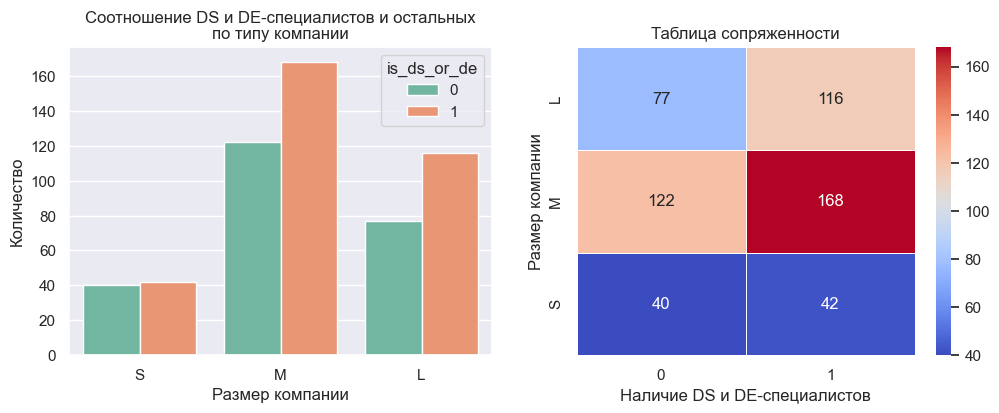

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(data=data, x=data['company_size'], hue='is_ds_or_de', order=['S', 'M', 'L'], ax=axes[0])
axes[0].set(xlabel='Размер компании', ylabel='Количество')
axes[0].set_title('Соотношение DS и DE-специалистов и остальных\nпо типу компании')

cross_tab = pd.crosstab(index=data['company_size'], columns=data['is_ds_or_de'])
sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm", ax=axes[1])
axes[1].set(xlabel='Наличие DS и DE-специалистов', ylabel='Размер компании')
axes[1].set_title('Таблица сопряженности')

plt.show()

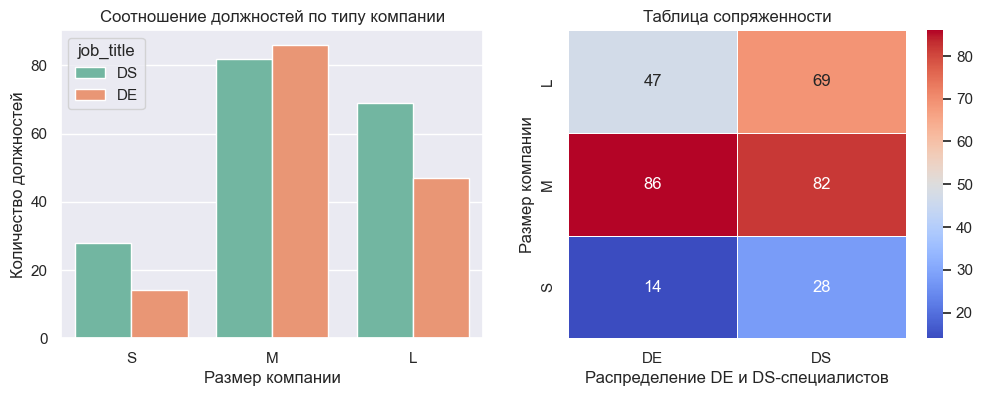

In [25]:
data_ds_de = data.copy()
data_ds_de = data_ds_de[data_ds_de['is_ds_or_de'] == 1]
data_ds_de['job_title'] = data_ds_de['is_ds'].apply(lambda x: 'DS' if x == 1 else 'DE')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = sns.countplot(data=data_ds_de, x=data_ds_de['company_size'], hue='job_title', order=['S', 'M', 'L'], ax=axes[0])
axes[0].set(xlabel='Размер компании', ylabel='Количество должностей')
axes[0].set_title('Соотношение должностей по типу компании')

cross_tab = pd.crosstab(index=data_ds_de['company_size'], columns=data_ds_de['job_title'])
sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm", ax=axes[1])
axes[1].set(xlabel='Распределение DE и DS-специалистов', ylabel='Размер компании')
axes[1].set_title('Таблица сопряженности')

plt.show()

In [26]:
ds_or_de_for_s = data[data['company_size'] == 'S']['is_ds_or_de'].value_counts(1)
print(f'Доля DS и DE-специалистов из компаний S-типа: {round(ds_or_de_for_s[1], 2)}', 
      f'Доля прочих специалистов из компаний S-типа:  {round(ds_or_de_for_s[0], 2)}\n',
      sep='\n')

ds_or_de_for_m = data[data['company_size'] == 'M']['is_ds_or_de'].value_counts(1)
print(f'Доля DS и DE-специалистов из компаний M-типа: {round(ds_or_de_for_m[1], 2)}', 
      f'Доля прочих специалистов из компаний M-типа:  {round(ds_or_de_for_m[0], 2)}\n',
      sep='\n')

ds_or_de_for_l = data[data['company_size'] == 'L']['is_ds_or_de'].value_counts(1)
print(f'Доля DS и DE-специалистов из компаний L-типа: {round(ds_or_de_for_l[1], 2)}', 
      f'Доля прочих специалистов из компаний L-типа:  {round(ds_or_de_for_l[0], 2)}',
      sep='\n')

Доля DS и DE-специалистов из компаний S-типа: 0.51
Доля прочих специалистов из компаний S-типа:  0.49

Доля DS и DE-специалистов из компаний M-типа: 0.58
Доля прочих специалистов из компаний M-типа:  0.42

Доля DS и DE-специалистов из компаний L-типа: 0.6
Доля прочих специалистов из компаний L-типа:  0.4


**Вывод**

Большая часть из представленных в наших данных DE-специалистов работает в средних компаниях (М-тип), число же DS-специалистов из средних компаний не на много превышает число таких же специалистов из больших компаний (L-тип). Меньше всего у нас данных о специалистах из небольших компаний (S-тип), однако DS-специалистов из таковых у нас вдвое больше, чем DE-специалистов. В целом же, составы распределений специалистов по типам компаний очень схожи - возможно, имеется статистически значимая взаимосвязь.

### Вывод по разделу

* Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist - да, наблюдается!
* Какие факторы влияют на зарплату у специалистов Data Scientist? - уровень квалификации специалиста, размер компании и страна трудоустройства влияют на уровень заработной платы.
* Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях? - заработная плата этих профессий зависит от размера компании, больше всего з/п в средних и больших компаниях - у DS-специалистов.
* Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании? - да, видно, что распределения должностей Data Engineer и Data Scientist по типам компаний достаточно похожи, чтобы утверждать о наличии некоторой связи.

---

## Статистический анализ данных

In [27]:
# Задаём уровень значимости.
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


Обозначим заранее ряд дежурных функций.

In [28]:
# Функция для принятия решения о нормальности.
def decision_normality(p):
    print(f'p-value = {p:.3f}')
    if p <= alpha:
        print('''p-значение меньше, чем заданный уровень значимости {:.2f}.
        Распределение отлично от нормального.\n'''.format(alpha))
    else:
        print('''p-значение больше, чем заданный уровень значимости {:.2f}.
        Распределение является нормальным.\n'''.format(alpha))

# Функция для принятия решения об отклонении нулевой гипотезы.
def decision_hypothesis(p):
    print(f'p-value = {p:.3f}')
    if p <= alpha:
        print('''p-значение меньше, чем заданный уровень значимости {:.2f}.
        Отвергаем нулевую гипотезу в пользу альтернативной.\n'''.format(alpha))
    else:
        print('''p-значение больше, чем заданный уровень значимости {:.2f}.
        У нас нет оснований отвергнуть нулевую гипотезу.\n'''.format(alpha))
        
# Функция для проверки на равенство диспесий.
def decision_dispersion(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
    else:
        print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

# Функция для статистической обработки неравных пар сравниваемых выборок.
def mw_rcycle_test(r, n, x, y, alt='two-sided'):
    """
    Выводит r-раз заключение функции decision_hypothesis для r-числа случайных рядов размерностью y 
    на основе более крупной выборки x из сравниваемой пары x-z с передачей вида альтернативной гипотезы
    в функцию stats.mannwhitneyu.
    Args:
        r (int): число повторов;
        x (pandas.Series): выборка-донор из сравниваемой пары;
        n (int): количесво случайно избранных значений из х;
        y (pandas.Series): вторая из сравниваемых выборок;
        alt (str): вид альтернативной гипотезы.
    Returns:
        Заключение функции decision_hypothesis r-число раз.
    """
    # Установка "зерна" датчика случайных чисел, чтобы обеспечить воспроизводимость отбора.
    random.seed(1)
    # Список для коллекции случайных значений.
    rand_vals_lst = []
    # Список для коллекции p-значений.
    p_vals = []
    # Цикл для обработки параметров, переданных в функцию.
    for i in range(r):
        rand_vals_lst = random.sample(list(x), n)
        _, p = stats.mannwhitneyu(rand_vals_lst, y, alternative=alt)
        p_vals.append(p)
    mean_p = sum(p_vals) / len(p_vals)
    print(f'Коллекция получившихся p-значений: {[round(p, 3) for p in p_vals]}',
          'Среднее значение:', sep='\n')
    decision_hypothesis(mean_p)

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер медианы зарплаты специалиста Data Science в 2020, 2021 и 2022 годах одинаковые:

$$ H_0: m_1 =m_2 =m_3 $$

*Альтернативная гипотеза*: размер медианы зарплаты специалиста Data Science в 2020, 2021 и 2022 годах отличаются:

$$ H_1: m_1 \neq m_2 \neq m_3 $$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [29]:
data_ds_20 = data_ds[data_ds['work_year']==2020]
data_ds_21 = data_ds[data_ds['work_year']==2021]
data_ds_22 = data_ds[data_ds['work_year']==2022]

In [30]:
print('2020 год:')
decision_normality(stats.shapiro(data_ds_20['salary_in_usd'])[1])
print('\n2021 год:')
decision_normality(stats.shapiro(data_ds_21['salary_in_usd'])[1])
print('\n2022 год:')
decision_normality(stats.shapiro(data_ds_22['salary_in_usd'])[1])

2020 год:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
        Распределение отлично от нормального.


2021 год:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
        Распределение отлично от нормального.


2022 год:
p-value = 0.038
p-значение меньше, чем заданный уровень значимости 0.05.
        Распределение отлично от нормального.



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработных плат»? — Количественный.
* Сколько сравниваемых групп? — три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Все распределения отличны от нормального.

Выбираем Критерий Краскела — Уоллиса (однофакторный дисперсионный анализ на рангах) является обобщением U-критерия Манна — Уитни на случай нескольких групп. Его используют, чтобы оценить различия медиан признака в двух и более независимых группах.

**Проведём тесты**

In [31]:
_, p = stats.kruskal(data_ds_20['salary_in_usd'], data_ds_21['salary_in_usd'], data_ds_22['salary_in_usd'])
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
        Отвергаем нулевую гипотезу в пользу альтернативной.



In [32]:
data_ds_20['salary_in_usd'].median() < data_ds_21['salary_in_usd'].median() < data_ds_22['salary_in_usd'].median()

True

**Вывод**

Мы действительно наблюдаем ежегодный рост зарплат у специалистов Data Science! Медианные значения растут из года в год, статистическая значимость гипотезы подтверждена

### Какие факторы влияют на зарплату у специалистов Data Scientist?

Для удобства расчетов закодируем признаки

In [33]:
# Обследуем очищенный от вспомогательных признаков датафрейм.
clear_ds_data = data_ds.iloc[:, :9]
cols_df = [x for x in clear_ds_data.columns if clear_ds_data[x].dtype == 'category']

In [34]:
# Кодируем признаки.
ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(clear_ds_data[cols_df])
data_cod = pd.concat([clear_ds_data, data_bin], axis=1)

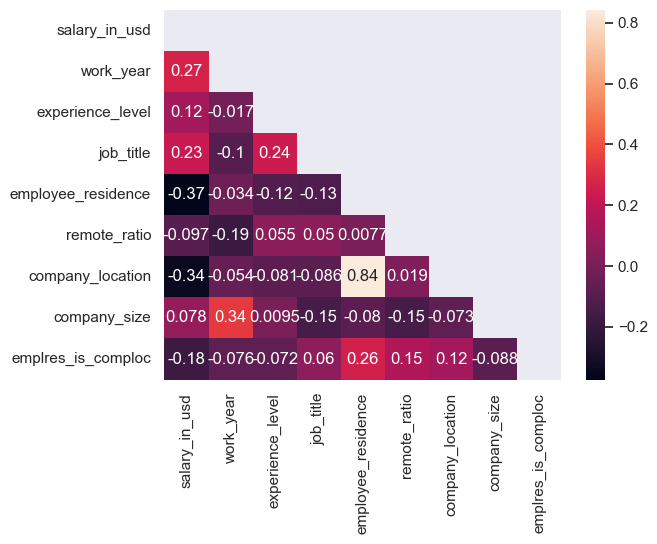

In [35]:
# Т.к. у нас появились категориальные признаки, мы испольщуем корреляцию Кендала: она устойчива к неочищенным данным.
data_corr = data_cod.corr(method = 'kendall')
# Выведем тепловую карту на основе матрицы корреляций.
matrix = np.triu(data_corr)
sns.heatmap(data_corr, annot=True, mask=matrix);

In [36]:
# Рассмотрем отдельно корреляции признаков с величиной заработной платы.
data_corr['salary_in_usd'].sort_values(ascending=False)

salary_in_usd         1.000000
work_year             0.270374
job_title             0.225822
experience_level      0.122986
company_size          0.078188
remote_ratio         -0.097147
emplres_is_comploc   -0.177313
company_location     -0.339092
employee_residence   -0.373660
Name: salary_in_usd, dtype: float64

**Вывод**

Как видим, имеется слабая связь со страной проживания специалиста и страной расположения компании (знаки нас в этом случае не интересуют: они являются следствием порядка кодирования значений признака). Незначительная связь имеется также с годом работы и названием должности: в нашей расширенной выборке содержатся не только простые наименования должностей Data Scientist.

### Влияет ли размер компании на заработную плату Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер зарплаты специалистов Data Scientist в маленьких($μ_1$), средних($μ_2$) и больших($μ_3$) компаниях одинаков:

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: размер зарплаты специалистов Data Scientist в маленьких($μ_1$), средних($μ_2$) и больших($μ_3$) компаниях неодинаков.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [37]:
data_ds_S = data_ds[data_ds['company_size']=='S']
data_ds_M = data_ds[data_ds['company_size']=='M']
data_ds_L = data_ds[data_ds['company_size']=='L']

In [38]:
print('\nДля компании S:')
decision_normality(stats.shapiro(data_ds_S['salary_in_usd'])[1])
print('\nДля компании M:')
decision_normality(stats.shapiro(data_ds_M['salary_in_usd'])[1])
print('\nДля компании L:')
decision_normality(stats.shapiro(data_ds_L['salary_in_usd'])[1])


Для компании S:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
        Распределение отлично от нормального.


Для компании M:
p-value = 0.785
p-значение больше, чем заданный уровень значимости 0.05.
        Распределение является нормальным.


Для компании L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
        Распределение отлично от нормального.



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста, для этого ответим на следующие вопросы:
* Какой тип у признака “зарплата”? - Количественный.
* Количество сравниваемых групп? - 3 группы.
* Группы зависимы? - Нет.
* Признак распределен по нормальному закону? - Нет.

Для проверки нашей гипотезы можем использовать Критерий Краскела-Уоллиса.

**Проведем тест**

In [39]:
_, p = stats.kruskal(data_ds_S['salary_in_usd'], data_ds_L['salary_in_usd'], data_ds_M['salary_in_usd'])
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
        Отвергаем нулевую гипотезу в пользу альтернативной.



**Вывод**

Размеры заработных плат DS-специалистов могут иметь статистически значимые различия в зависимости от размера компании работодателя.

### Размеры заработных плат удаленщиков выше, чем у офисных работников?

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза* ($H_0$): размеры заработных плат удаленщиков ($μ_1$) статистически меньше либо равны размерам заработных плат офисных работников ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размеры заработных плат удаленщиков ($μ_1$) статистически больше, чем размеры заработных плат офисных работников ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [40]:
# Выбираем значения из соответствующих групп.
slrs_for_remrat0 = data.loc[data['remote_ratio']==0, 'salary_in_usd']
slrs_for_remrat100 = data.loc[data['remote_ratio']==100, 'salary_in_usd']
ds_slrs_for_remrat0 = data_ds.loc[data_ds['remote_ratio']==0, 'salary_in_usd']
ds_slrs_for_remrat100 = data_ds.loc[data_ds['remote_ratio']==100, 'salary_in_usd']
de_slrs_for_remrat0 = data_de.loc[data_de['remote_ratio']==0, 'salary_in_usd']
de_slrs_for_remrat100 = data_de.loc[data_de['remote_ratio']==100, 'salary_in_usd']

# Проводим тест Шапиро-Уилка.
print('Для общего распределения зарплат офисных работников:')
result = stats.shapiro(slrs_for_remrat0)
decision_normality(result[1])

print('Для общего распределения зарплат удаленщиков:')
result = stats.shapiro(slrs_for_remrat100)
decision_normality(result[1])

print('Для распределения зарплат офисных DS-специалистов:')
result = stats.shapiro(ds_slrs_for_remrat0)
decision_normality(result[1])

print('Для распределения зарплат DS-удаленщиков:')
result = stats.shapiro(ds_slrs_for_remrat100)
decision_normality(result[1])

print('Для распределения зарплат офисных DE-специалистов:')
result = stats.shapiro(de_slrs_for_remrat0)
decision_normality(result[1])

print('Для распределения зарплат DE-удаленщиков:')
result = stats.shapiro(de_slrs_for_remrat100)
decision_normality(result[1])

Для общего распределения зарплат офисных работников:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
        Распределение отлично от нормального.

Для общего распределения зарплат удаленщиков:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
        Распределение отлично от нормального.

Для распределения зарплат офисных DS-специалистов:
p-value = 0.323
p-значение больше, чем заданный уровень значимости 0.05.
        Распределение является нормальным.

Для распределения зарплат DS-удаленщиков:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
        Распределение отлично от нормального.

Для распределения зарплат офисных DE-специалистов:
p-value = 0.231
p-значение больше, чем заданный уровень значимости 0.05.
        Распределение является нормальным.

Для распределения зарплат DE-удаленщиков:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
        Распределение отлично от нормального.



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработных плат»? — Количественный.
* Сколько сравниваемых групп? — по две на каждый датафрейм.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нормальное распределениe признака наблюдается только в выборках для офисных работников DS и DE подгрупп.

Чтобы проверить нашу гипотезу, мы все же воспольземся U-критерием Манна-Уитни для сравнения распределений на основе рангов, т.к. не все выборки из сравниваемых пар состоят из значений распределенных нормально.

**Оценим величины выборок**

Прежде чем проводить тесты, оценим величины получившихся выборок.

In [41]:
print(f'Число учтенных офисных работников в общей группе: {len(slrs_for_remrat0)}',
      f'Число учтенных удаленщиков в общей группе: {len(slrs_for_remrat100)}\n',
      sep='\n')
print(f'Число учтенных офисных работников в DS-группе: {len(ds_slrs_for_remrat0)}',
      f'Число учтенных удаленщиков в DS-группе: {len(ds_slrs_for_remrat100)}\n',
      sep='\n')
print(f'Число учтенных офисных работников в DE-группе: {len(de_slrs_for_remrat0)}',
      f'Число учтенных удаленщиков в DE-группе: {len(de_slrs_for_remrat100)}\n',
      sep='\n')

Число учтенных офисных работников в общей группе: 121
Число учтенных удаленщиков в общей группе: 346

Число учтенных офисных работников в DS-группе: 48
Число учтенных удаленщиков в DS-группе: 98

Число учтенных офисных работников в DE-группе: 32
Число учтенных удаленщиков в DE-группе: 97



Удаленщиков во всех группах оказалось больше всего. В данном случае также придется прибегнуть к случайному отбору значений и умножению тестируемых пар выборок. В этот раз создадим по 10 случайно избранных рядов для выборок удаленщиков.

**Проведём тесты**

In [42]:
# Тесты для выборок из общей группы.
mw_rcycle_test(10, 127, slrs_for_remrat100, slrs_for_remrat0, alt='greater')

Коллекция получившихся p-значений: [0.026, 0.054, 0.042, 0.025, 0.033, 0.036, 0.055, 0.008, 0.008, 0.108]
Среднее значение:
p-value = 0.039
p-значение меньше, чем заданный уровень значимости 0.05.
        Отвергаем нулевую гипотезу в пользу альтернативной.



In [43]:
# Тесты для выборок из DS-группы.
mw_rcycle_test(10, 49, ds_slrs_for_remrat100, ds_slrs_for_remrat0, alt='greater')

Коллекция получившихся p-значений: [0.109, 0.074, 0.003, 0.034, 0.055, 0.103, 0.071, 0.022, 0.157, 0.092]
Среднее значение:
p-value = 0.072
p-значение больше, чем заданный уровень значимости 0.05.
        У нас нет оснований отвергнуть нулевую гипотезу.



In [44]:
# Тесты для выборок из DE-группы.
mw_rcycle_test(10, 32, de_slrs_for_remrat100, de_slrs_for_remrat0, alt='greater')

Коллекция получившихся p-значений: [0.16, 0.236, 0.127, 0.286, 0.111, 0.133, 0.023, 0.079, 0.033, 0.075]
Среднее значение:
p-value = 0.126
p-значение больше, чем заданный уровень значимости 0.05.
        У нас нет оснований отвергнуть нулевую гипотезу.



**Вывод**

Получилась весьма интересная ситуация: в отношении общей группы мы можем утверждать, что удаленщики действительно получают больше; но в отношении же DS и DE-подгрупп мы так сказать не можем.

### Влияет ли размер компании на заработную плату специалистов?

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза* ($H_0$): размеры заработных плат специалистов из крупных (L) компаний ($μ_1$) статистически меньше либо равны размерам заработных плат специалистов из средних (M) компаний  ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размеры заработных специалистов из крупных (L) компаний ($μ_1$) статистически больше, чем размеры заработных плат специалистов из средних (M) компаний ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [45]:
# Выбираем значения из соответствующих групп.
slrs_for_csM = data.loc[data['company_size']=='M', 'salary_in_usd']
slrs_for_csL = data.loc[data['company_size']=='L', 'salary_in_usd']
ds_slrs_for_csM = data_ds.loc[data_ds['company_size']=='M', 'salary_in_usd']
ds_slrs_for_csL = data_ds.loc[data_ds['company_size']=='L', 'salary_in_usd']
de_slrs_for_csM = data_de.loc[data_de['company_size']=='M', 'salary_in_usd']
de_slrs_for_csL = data_de.loc[data_de['company_size']=='L', 'salary_in_usd']

# Проводим тест Шапиро-Уилка.
print('Для общего распределения зарплат специалистов из средних (M) компаний:')
result = stats.shapiro(slrs_for_csM)
decision_normality(result[1])

print('Для общего распределения зарплат специалистов из крупных (L) компаний:')
result = stats.shapiro(slrs_for_csL)
decision_normality(result[1])

print('Для распределения зарплат DS-специалистов из средних (M) компаний:')
result = stats.shapiro(ds_slrs_for_csM)
decision_normality(result[1])

print('Для распределения зарплат DS-специалистов из крупных (L) компаний:')
result = stats.shapiro(ds_slrs_for_csL)
decision_normality(result[1])

print('Для распределения зарплат DE-специалистов из средних (M) компаний:')
result = stats.shapiro(de_slrs_for_csM)
decision_normality(result[1])

print('Для распределения зарплат DE-специалистов из крупных (L) компаний:')
result = stats.shapiro(de_slrs_for_csL)
decision_normality(result[1])

Для общего распределения зарплат специалистов из средних (M) компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
        Распределение отлично от нормального.

Для общего распределения зарплат специалистов из крупных (L) компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
        Распределение отлично от нормального.

Для распределения зарплат DS-специалистов из средних (M) компаний:
p-value = 0.785
p-значение больше, чем заданный уровень значимости 0.05.
        Распределение является нормальным.

Для распределения зарплат DS-специалистов из крупных (L) компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
        Распределение отлично от нормального.

Для распределения зарплат DE-специалистов из средних (M) компаний:
p-value = 0.055
p-значение больше, чем заданный уровень значимости 0.05.
        Распределение является нормальным.

Для распределения зарплат DE-специалистов из крупных (L) компан

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработных плат»? — Количественный.
* Сколько сравниваемых групп? — по две на каждый датафрейм.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нормальное распределениe признака наблюдается только в выборках для сотрудников средних компаний в DS и DE подгруппах.

Чтобы проверить нашу гипотезу, мы все же воспольземся U-критерием Манна-Уитни для сравнения распределений на основе рангов, т.к. не все выборки из сравниваемых пар состоят из значений распределенных нормально.

**Оценим величины выборок**

Прежде чем проводить тесты, оценим величины получившихся выборок.

In [46]:
print(f'Число учтенных специалистов из средних (M) компаний: {len(slrs_for_csM)}',
      f'Число учтенных специалистов из крупных (L) компаний: {len(slrs_for_csL)}\n',
      sep='\n')
print(f'Число учтенных DS-специалистов из средних (M) компаний: {len(ds_slrs_for_csM)}',
      f'Число учтенных DS-специалистов из крупных (L) компаний: {len(ds_slrs_for_csL)}\n',
      sep='\n')
print(f'Число учтенных DE-специалистов из средних (M) компаний: {len(de_slrs_for_csM)}',
      f'Число учтенных DE-специалистов из крупных (L) компаний: {len(de_slrs_for_csL)}\n',
      sep='\n')

Число учтенных специалистов из средних (M) компаний: 290
Число учтенных специалистов из крупных (L) компаний: 193

Число учтенных DS-специалистов из средних (M) компаний: 82
Число учтенных DS-специалистов из крупных (L) компаний: 69

Число учтенных DE-специалистов из средних (M) компаний: 86
Число учтенных DE-специалистов из крупных (L) компаний: 47



Во всех трех группах сотрудники средних компаний представлены большим числом.

**Проведём тесты**

In [47]:
# Тесты для выборок из общей группы.
mw_rcycle_test(10, 193, slrs_for_csM, slrs_for_csL, alt='greater')

Коллекция получившихся p-значений: [0.082, 0.183, 0.286, 0.422, 0.093, 0.075, 0.147, 0.068, 0.267, 0.052]
Среднее значение:
p-value = 0.168
p-значение больше, чем заданный уровень значимости 0.05.
        У нас нет оснований отвергнуть нулевую гипотезу.



In [48]:
# Тесты для выборок из DS-группы.
mw_rcycle_test(10, 69, ds_slrs_for_csM, ds_slrs_for_csL, alt='greater')

Коллекция получившихся p-значений: [0.159, 0.193, 0.196, 0.097, 0.313, 0.141, 0.163, 0.221, 0.143, 0.187]
Среднее значение:
p-value = 0.181
p-значение больше, чем заданный уровень значимости 0.05.
        У нас нет оснований отвергнуть нулевую гипотезу.



In [49]:
# Тесты для выборок из DE-группы.
mw_rcycle_test(10, 47, de_slrs_for_csM, de_slrs_for_csL, alt='greater')

Коллекция получившихся p-значений: [0.2, 0.126, 0.191, 0.143, 0.034, 0.142, 0.173, 0.141, 0.071, 0.092]
Среднее значение:
p-value = 0.131
p-значение больше, чем заданный уровень значимости 0.05.
        У нас нет оснований отвергнуть нулевую гипотезу.



**Вывод**

Мы не можем заявить, что специалисты в крупных компаниях получают больше, чем специалисты из средних компаний.

### Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?

**Сформулируем нулевую и альтернативную гипотезы**

Они будут общими для всех трех (по виду компаний: S, M, L) сравниваемых случаев.

*Нулевая гипотеза* ($H_0$): размеры заработных плат DS-специалистов ($μ_1$) статистически меньше либо равны размерам заработных плат DE-специалистов ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размеры заработных DS-специалистов ($μ_1$) статистически больше, чем размеры заработных плат DE-специалистов ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

На нормальность осталось проверить только выборки специалистов из маленьких компаний.

In [50]:
# Выбираем значения из соответствующих групп.
ds_slrs_for_csS = data_ds.loc[data_ds['company_size']=='S', 'salary_in_usd']
de_slrs_for_csS = data_de.loc[data_de['company_size']=='S', 'salary_in_usd']

print('Для распределения зарплат DS-специалистов из маленьких (S) компаний:')
result = stats.shapiro(ds_slrs_for_csS)
decision_normality(result[1])

print('Для распределения зарплат DE-специалистов из маленьких (S) компаний:')
result = stats.shapiro(de_slrs_for_csS)
decision_normality(result[1])

Для распределения зарплат DS-специалистов из маленьких (S) компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
        Распределение отлично от нормального.

Для распределения зарплат DE-специалистов из маленьких (S) компаний:
p-value = 0.588
p-значение больше, чем заданный уровень значимости 0.05.
        Распределение является нормальным.



Продублируем результаты проверки на нормальность из предыдущего тестирования:

* Для распределения зарплат DS-специалистов из средних (M) компаний:
  p-value = 0.565;
  p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.

* Для распределения зарплат DS-специалистов из крупных (L) компаний:
  p-value = 0.000;
  p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.

* Для распределения зарплат DE-специалистов из средних (M) компаний:
  p-value = 0.074;
  p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.

* Для распределения зарплат DE-специалистов из крупных (L) компаний:
  p-value = 0.000;
  p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработных плат»? — Количественный.
* Сколько сравниваемых групп? — по две выборки на каждый случай.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — в паре выборок для специалистов из небольших компаний лишь одна содержит нормально распределенные значения; в паре для М-компаний обе выборки распределены нормально; в паре для L-компаний - обе выборки с ненормальным распределением.

Чтобы проверить нашу гипотезу для выборочных пар специалистов из S и L-компаний воспользуемся U-критерием Манна-Уитни. В случае же выборок специалистов из М-компаний целесообразно использовать двухвыборочный t-критерий.

**Оценим величины выборок**

Прежде чем проводить тесты, оценим величины получившихся выборок.

In [51]:
print(f'Число учтенных DS-специалистов небольших (S) компаний: {len(ds_slrs_for_csS)}',
      f'Число учтенных DE-специалистов небольших (S) компаний: {len(de_slrs_for_csS)}\n',
      sep='\n')

Число учтенных DS-специалистов небольших (S) компаний: 28
Число учтенных DE-специалистов небольших (S) компаний: 14



Продублируем числовые характеристики получившихся выборок: 
* Число учтенных DS-специалистов из средних (M) компаний: 93
* Число учтенных DS-специалистов из крупных (L) компаний: 71
* Число учтенных DE-специалистов из средних (M) компаний: 94
* Число учтенных DE-специалистов из крупных (L) компаний: 50

Размеры выборок, к счастью, не сошлись именно для S и L-компаний: у нас уже имеется специальная функция для таких случаев. Размеры выборок для М-компаний практически равны и дополнительных действий над собой не требуют.

**Проведём тесты**

Сперва займемся выборками для М-компаний.

In [58]:
# Проведем тест Левена на равенство дисперсий.
print('Тест на равенство дисперсий')
result = stats.levene(ds_slrs_for_csM, de_slrs_for_csM)
p = result[1]

# Интерпретируем результат.
decision_dispersion(p)

# Проводим тест на сравнение средних в группах.
print('\nТест на равенство средних')
_, p = stats.ttest_ind(ds_slrs_for_csM, de_slrs_for_csM, alternative='greater', equal_var=True)
decision_hypothesis(p)

Тест на равенство дисперсий
p-value = 0.900
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.

Тест на равенство средних
p-value = 0.229
p-значение больше, чем заданный уровень значимости 0.05.
        У нас нет оснований отвергнуть нулевую гипотезу.



In [53]:
# В образовательных целях можем пропустить те же выборки через тест с U-критерием Манна-Уитни.
mw_rcycle_test(10, 82, de_slrs_for_csM, ds_slrs_for_csM, alt='less')

Коллекция получившихся p-значений: [0.102, 0.178, 0.124, 0.119, 0.147, 0.112, 0.137, 0.082, 0.1, 0.165]
Среднее значение:
p-value = 0.127
p-значение больше, чем заданный уровень значимости 0.05.
        У нас нет оснований отвергнуть нулевую гипотезу.



In [54]:
# Тест для выборок специалистов из небольших (S) компаний.
mw_rcycle_test(10, 14, ds_slrs_for_csS, de_slrs_for_csS, alt='greater')

Коллекция получившихся p-значений: [0.838, 0.635, 0.747, 0.74, 0.849, 0.875, 0.884, 0.929, 0.919, 0.709]
Среднее значение:
p-value = 0.813
p-значение больше, чем заданный уровень значимости 0.05.
        У нас нет оснований отвергнуть нулевую гипотезу.



In [59]:
# Тест для выборок специалистов из крупных (L) компаний.
mw_rcycle_test(10, 50, ds_slrs_for_csL, de_slrs_for_csL, alt='greater')

Коллекция получившихся p-значений: [0.089, 0.205, 0.309, 0.107, 0.113, 0.16, 0.157, 0.221, 0.388, 0.154]
Среднее значение:
p-value = 0.190
p-значение больше, чем заданный уровень значимости 0.05.
        У нас нет оснований отвергнуть нулевую гипотезу.



**Вывод**

Заявления о принципиальной разности заработных плат DS и DE-специалистов в зависимости от размера компаний, пожалуй, не могут опереться на результаты проведенных нами статистических тестов. Быть может, если бы мы выбрали менее строгий уровень значимости (например, 0.1), то смогли бы утверждать, что, как минимум, заработные платы специалистов из средних компаний несколько сильнее отличаются - в большую сторону для DS-специалистов.

### Есть ли связь между должностями Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза*: признаки «Должность» и «Размер компании» независимы.

*Альтернативная гипотеза*: признаки «Должность» и «Размер компании» взаимосвязаны

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер компании»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [62]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(data['is_ds_or_de'], data['company_size'])

data_ds_de = data[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')]
cross_table = pd.crosstab(data_ds_de['job_title'], data_ds_de['company_size'])

cross_table

company_size,L,M,S
job_title,,,
Data Engineer,34,81,6
Data Scientist,43,66,21


In [63]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05.
        Отвергаем нулевую гипотезу в пользу альтернативной.



**Вывод**

Похоже, нам удалось установить наличие статистически значимой взаимосвязи между размером компании и должностями DS и DE.

---

## Итоговые результаты исследования

*   Мы действительно наблюдаем ежегодный рост зарплат у специалистов Data Science.
*   На зарплату специалистов Data Science влияют:
    * Уровень квалификации.
    * Страна проживания специалиста.
    * Страна расположения компании.
    * Размер компании.
*   Зарплаты Data Scientist и Data Engineer в разрезе типов компаний не имеют принципиальных различий, и, скорее всего, представляют собой наборы значений одной и той же генеральной совокупности.
*   Существует взаимосвязь между размером компании и должностями Data Scientist и Data Engineer.
*   Специалисты Data Science работающие удаленно получают примерно такую же заработную плату, что и DS-специалисты, работающие в офисе.
*   DE и DS-специалисты из компаний одного типа получают примерно одинаковую заработную плату.